# 0) Setup, Pfade, Daten laden, Aufbereitung

In [40]:
## Pakete
req <- c("readxl","psych","dplyr","ggplot2","factoextra","corrplot","tibble","knitr")
to_install <- req[!req %in% rownames(installed.packages())]
if(length(to_install)) install.packages(to_install, quiet = TRUE)
invisible(lapply(req, library, character.only = TRUE))

## Pfade
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A")
if(!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

## Helper (keine HTML-Ausgabe)
show_h1 <- function(txt) cat("\n\n==== ", txt, " ====\n", sep="")
note    <- function(txt)  cat("Anmerkung: ", txt, "\n", sep = "")
show_tbl<- function(df, caption=NULL) print(knitr::kable(df, format="simple", caption=caption, align="l"))
to_numeric_df <- function(df){
  out <- df
  out[] <- lapply(out, function(x){
    if(is.character(x) || is.factor(x)){ x <- gsub(",", ".", as.character(x)); suppressWarnings(as.numeric(x)) }
    else { suppressWarnings(as.numeric(x)) }
  })
  out
}

## Daten laden (erste Excel im Ordner; erstes Sheet)
excel_file <- list.files(base_dir, pattern="\\.xlsx?$", full.names=TRUE)
stopifnot("Keine Excel-Datei gefunden." = length(excel_file) > 0)
excel_file <- excel_file[1]
sheet_name <- readxl::excel_sheets(excel_file)[1]
raw <- read_excel(excel_file, sheet = sheet_name)

## Variablen exakt wie genutzt (14)
vars_all <- c(
  "average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
  "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
  "pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5","Air_temp"
)
stopifnot(all(vars_all %in% names(raw)))
dat <- raw[, vars_all, drop = FALSE]

## Numerisch + vollständige Fälle
dat_num <- to_numeric_df(dat)
n0 <- nrow(dat_num)
dat_cc <- na.omit(dat_num)
n_removed <- n0 - nrow(dat_cc)

show_h1("Datenbasis")
note("Nur vollständige Zeilen (keine NA) werden verwendet.")
show_tbl(data.frame(Gesamt_Faelle=n0, Vollstaendige_Faelle=nrow(dat_cc), Entfernte_Zeilen_mit_NA=n_removed),
         "Fallzahlen")





==== Datenbasis ====
Anmerkung: Nur vollständige Zeilen (keine NA) werden verwendet.


Table: Fallzahlen

Gesamt_Faelle   Vollstaendige_Faelle   Entfernte_Zeilen_mit_NA 
--------------  ---------------------  ------------------------
57              27                     30                      


# 1) Korrelation & positive Definitheit (PD)

In [41]:
## === Prüfe PD-Eigenschaft bei 14 Variablen & zeige Ursache (kompakt, Jupyter) ===
suppressPackageStartupMessages(library(Matrix))
if(!exists("show_h1"))  show_h1  <- function(x) cat("\n\n==== ", x, " ====\n", sep="")
if(!exists("show_tbl")) show_tbl <- function(df, caption=NULL) print(knitr::kable(df, format="simple", caption=caption, align="l"))

vars14 <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
            "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
            "pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5","Air_temp")
vars14 <- intersect(vars14, colnames(dat_cc))

X14 <- dat_cc[, vars14, drop=FALSE]                    # vollständige Fälle
R14 <- cor(X14, use="complete.obs"); R14 <- (R14+t(R14))/2  # exakt symmetrieren

ev14 <- eigen(R14, symmetric=TRUE)$values
tol  <- 1e-8
status14 <- if (min(ev14) > tol) "positiv-definit" else if (min(ev14) < -tol) "NICHT positiv-definit" else "positiv-semidefinit (singulär)"
rank_eff  <- as.integer(rankMatrix(R14))              # numerischer Rang
cond_num  <- max(ev14)/max(tol, min(ev14[ev14>tol], na.rm=TRUE))  # Konditionszahl ~ κ

show_h1("Eigenwerte (14 Variablen)")
ev_tab <- data.frame(Index = seq_along(ev14), Eigenwert = round(ev14, 6))
show_tbl(ev_tab, "Eigenwerte der Korrelationsmatrix (14)")
cat(sprintf("Status: %s | kleinster EV = %.10g | det(R) = %.3e | Rang = %d/%d | κ ≈ %.2e\n",
            status14, min(ev14), det(R14), rank_eff, ncol(R14), cond_num))

# ---- Ursache: sehr hohe Korrelationen (v. a. pctComp.*) ----
hi <- which(abs(R14) > 0.95 & upper.tri(R14), arr.ind=TRUE)
if(nrow(hi)){
  pairs <- data.frame(
    Var1 = rownames(R14)[hi[,1]],
    Var2 = colnames(R14)[hi[,2]],
    r    = round(R14[hi], 3)
  )[order(-abs(R14[hi])), ]
  show_h1("Sehr hohe Korrelationen (|r| > 0.95)")
  show_tbl(pairs, "Hinweis auf Kollinearität")
}

pc <- grep("^pctComp\\.", colnames(R14), value=TRUE)
if(length(pc) > 1){
  Rpc  <- R14[pc, pc, drop=FALSE]
  evpc <- eigen((Rpc+t(Rpc))/2, symmetric=TRUE)$values
  show_h1("Submatrix pctComp.* (Eigenwerte)")
  show_tbl(data.frame(Index=seq_along(evpc), Eigenwert=round(evpc,6)),
           "Eigenwerte der pctComp-Submatrix")
}

# ---- Vergleich: Entferne pctComp.1/.4/.5 (wie im Dokument) ----
drop <- intersect(c("pctComp.1","pctComp.4","pctComp.5"), colnames(X14))
X11  <- X14[, setdiff(colnames(X14), drop), drop=FALSE]
R11  <- cor(X11, use="complete.obs"); R11 <- (R11+t(R11))/2
ev11 <- eigen(R11, symmetric=TRUE)$values
status11 <- if (min(ev11) > tol) "positiv-definit" else if (min(ev11) < -tol) "NICHT positiv-definit" else "positiv-semidefinit (singulär)"

show_h1(sprintf("Eigenwerte nach Entfernen: %s", paste(drop, collapse=", ")))
show_tbl(data.frame(Index=seq_along(ev11), Eigenwert=round(ev11,6)),
         "Eigenwerte der Korrelationsmatrix (11)")
cat(sprintf("Status: %s | kleinster EV = %.6f\n", status11, min(ev11)))




==== Eigenwerte (14 Variablen) ====


Table: Eigenwerte der Korrelationsmatrix (14)

Index   Eigenwert 
------  ----------
1       5.795871  
2       2.039052  
3       1.676643  
4       1.528115  
5       0.946461  
6       0.799645  
7       0.556906  
8       0.238270  
9       0.192866  
10      0.101027  
11      0.078267  
12      0.036042  
13      0.010835  
14      0.000000  
Status: positiv-semidefinit (singulär) | kleinster EV = 1.309716224e-16 | det(R) = 5.380e-22 | Rang = 13/14 | κ ≈ 5.35e+02


==== Submatrix pctComp.* (Eigenwerte) ====


Table: Eigenwerte der pctComp-Submatrix

Index   Eigenwert 
------  ----------
1       2.834385  
2       1.532188  
3       0.602266  
4       0.031161  
5       0.000000  


==== Eigenwerte nach Entfernen: pctComp.1, pctComp.4, pctComp.5 ====


Table: Eigenwerte der Korrelationsmatrix (11)

Index   Eigenwert 
------  ----------
1       5.226529  
2       1.984322  
3       1.141117  
4       0.964681  
5       0.613607  
6       0.50



==== Korrelationsmatrix (alle Variablen) ====


Table: Korrelationskoeffizienten (Pearson)

                     average_DOC_sample   BDOC_pct   CO2_Flux   Chlorophyll_ugperL   ODO_mgperL   BGA_PC_ugperL   Turbidity_FNU   pH      pctComp.1   pctComp.2   pctComp.3   pctComp.4   pctComp.5   Air_temp 
-------------------  -------------------  ---------  ---------  -------------------  -----------  --------------  --------------  ------  ----------  ----------  ----------  ----------  ----------  ---------
average_DOC_sample   1.00                 0.47       -0.30      -0.20                0.38         0.00            0.10            -0.26   -0.30       -0.35       0.44        -0.22       0.01        -0.11    
BDOC_pct             0.47                 1.00       0.19       -0.33                -0.13        -0.06           0.14            -0.38   -0.10       0.29        -0.15       0.41        -0.24       -0.30    
CO2_Flux             -0.30                0.19       1.00       -0.48     

pdf 
  2

Anmerkung: PNG gespeichert: 01a_Corrplot_ALLE.png


==== Eigenwerte (Diagnose) ====


Table: Status: positiv-semidefinit (singulär) | kleinster EV = 2.949029909e-17 | Rang = 13/14 | κ ≈ 5.35e+02

Index   Eigenwert 
------  ----------
1       5.795871  
2       2.039052  
3       1.676643  
4       1.528115  
5       0.946461  
6       0.799645  
7       0.556906  
8       0.238270  
9       0.192866  
10      0.101027  
11      0.078267  
12      0.036042  
13      0.010835  
14      0.000000  
Anmerkung: Matrix ist nicht strikt PD → PCA/Faktoranalyse problematisch.


==== pctComp.* – Eigenwerte der Submatrix ====


Table: Status: positiv-semidefinit | kleinster EV = -0.000000

Index   Eigenwert 
------  ----------
1       2.834385  
2       1.532188  
3       0.602266  
4       0.031161  
5       0.000000  


==== Empfehlung (nur innerhalb pctComp.* entfernt) ====


Table: Kleinste Kombination, die die Gesamtmatrix positiv-definit macht

Entfernt    p    min_Eigenwert 
----------  ---

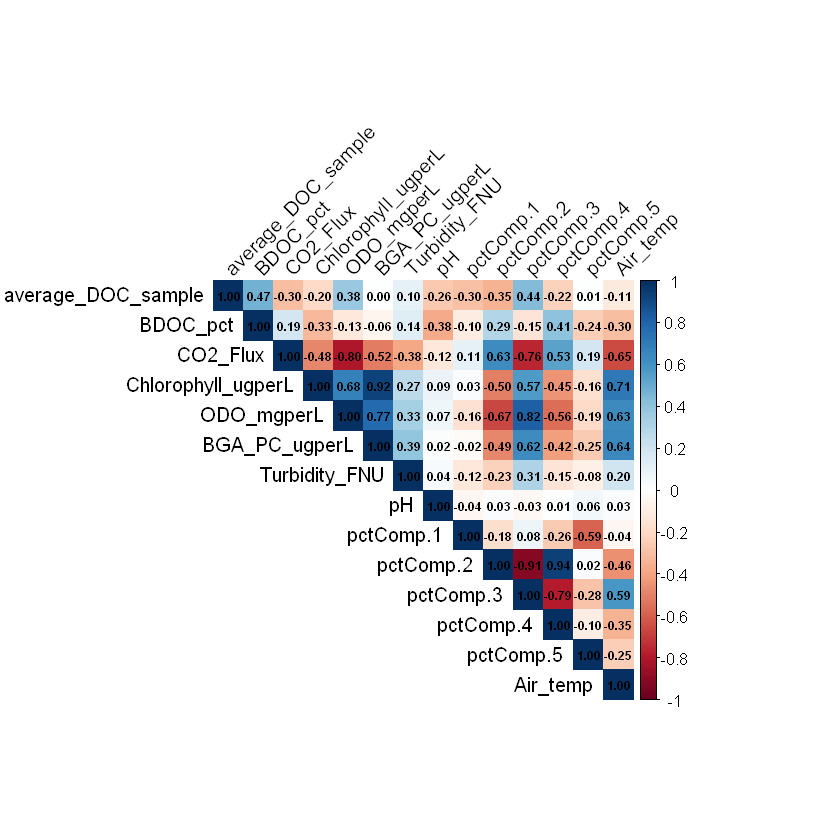

In [42]:
## Korrelationsmatrix & Eigenwerte
R_all <- cor(dat_cc, use = "pairwise.complete.obs")
eig_all <- eigen(R_all, symmetric = TRUE, only.values = TRUE)$values

## Speichern + Anzeige (neuer Ordner PCA_A)
write.csv(round(R_all, 3), file.path(out_dir, "01_Korrelationsmatrix_ALLE.csv"))
show_h1("Korrelationsmatrix (alle Variablen)")
show_tbl(round(R_all, 2), "Korrelationskoeffizienten (Pearson)")

ev_df <- data.frame(Index=seq_along(eig_all), Eigenwert=round(eig_all,6))
show_tbl(ev_df, "Eigenwerte der Korrelationsmatrix")
min_eig <- min(eig_all)
if(min_eig > 0) {
  cat(sprintf("✅ Positiv-definit. Kleinster Eigenwert = %0.6f\n", min_eig))
} else {
  cat(sprintf("⚠️ NICHT positiv-definit. Kleinster Eigenwert = %0.6f\n", min_eig))
}

## Corrplot (PNG + Anzeige, Speicherordner PCA_A)
png(file.path(out_dir, "01a_Corrplot_ALLE.png"), width = 1800, height = 1600, res = 200)
corrplot(R_all, method="color", type="upper", tl.col="black", tl.srt=45, addCoef.col="black", number.cex=0.6)
dev.off()
corrplot(R_all, method="color", type="upper", tl.col="black", tl.srt=45, addCoef.col="black", number.cex=0.6)
note("PNG gespeichert: 01a_Corrplot_ALLE.png")






## === PD-Check + Begründung + Empfehlung (nur pctComp.* entfernen) ===
suppressPackageStartupMessages(library(Matrix))

# 1) robuste Eigenwerte + Status
R_all <- (R_all + t(R_all)) / 2
ev  <- eigen(R_all, symmetric = TRUE, only.values = TRUE)$values
tol <- 1e-8

if (min(ev) > tol) {
  status <- "positiv-definit"
} else if (min(ev) < -tol) {
  status <- "NICHT positiv-definit"
} else {
  status <- "positiv-semidefinit (singulär)"
}

rk     <- as.integer(Matrix::rankMatrix(R_all))
pos_ev <- ev[ev > tol]
kappa  <- if (length(pos_ev)) max(ev) / min(pos_ev) else Inf

show_h1("Eigenwerte (Diagnose)")
show_tbl(data.frame(Index=seq_along(ev), Eigenwert=round(ev,6)),
         sprintf("Status: %s | kleinster EV = %.10g | Rang = %d/%d | κ ≈ %.2e",
                 status, min(ev), rk, ncol(R_all), kappa))
if (status != "positiv-definit") cat("Anmerkung: Matrix ist nicht strikt PD → PCA/Faktoranalyse problematisch.\n")

# 2) sehr hohe Korrelationen (Hinweis auf Kollinearität)
thr <- 0.95
hi  <- which(abs(R_all) > thr & upper.tri(R_all), arr.ind = TRUE)
if (nrow(hi) > 0) {
  kor_df <- data.frame(
    Var1 = rownames(R_all)[hi[,1]],
    Var2 = colnames(R_all)[hi[,2]],
    r    = round(R_all[hi], 3)
  )[order(-abs(R_all[hi])), ]
  show_h1(sprintf("Sehr hohe Korrelationen (|r| > %.2f)", thr))
  show_tbl(kor_df, "Mögliche Kollinearitätstreiber")
}

# 3) pctComp-Submatrix separat prüfen
comp_vars <- grep("^pctComp\\.", colnames(R_all), value = TRUE)
if (length(comp_vars) >= 2) {
  Rc  <- R_all[comp_vars, comp_vars, drop=FALSE]
  Rc  <- (Rc + t(Rc)) / 2
  evc <- eigen(Rc, symmetric=TRUE, only.values=TRUE)$values
  if (min(evc) > tol) {
    stc <- "positiv-definit"
  } else if (min(evc) < -tol) {
    stc <- "NICHT positiv-definit"
  } else {
    stc <- "positiv-semidefinit"
  }
  show_h1("pctComp.* – Eigenwerte der Submatrix")
  show_tbl(data.frame(Index=seq_along(evc), Eigenwert=round(evc,6)),
           sprintf("Status: %s | kleinster EV = %.6f", stc, min(evc)))
}

# 4) nur unter pctComp.*: kleinste Entfernen-Kombi, die R_all positiv-definit macht
if (status != "positiv-definit" && length(comp_vars) >= 1) {
  all_vars   <- colnames(R_all)
  other_vars <- setdiff(all_vars, comp_vars)
  best <- NULL

  for (k in seq_along(comp_vars)) {            # erst 1 entfernen, dann 2, ...
    cmb <- combn(comp_vars, k, simplify = FALSE)
    for (rem in cmb) {
      keep <- c(other_vars, setdiff(comp_vars, rem))
      Rk   <- cor(dat_cc[, keep, drop=FALSE], use="complete.obs")
      Rk   <- (Rk + t(Rk)) / 2
      evk  <- eigen(Rk, symmetric=TRUE, only.values=TRUE)$values
      if (min(evk) > tol) {
        cand <- data.frame(Entfernt=paste(rem, collapse=", "),
                           p=length(keep),
                           min_Eigenwert=min(evk),
                           stringsAsFactors=FALSE)
        if (is.null(best) || cand$min_Eigenwert > best$min_Eigenwert) best <- cand
      }
    }
    if (!is.null(best)) break
  }

  show_h1("Empfehlung (nur innerhalb pctComp.* entfernt)")
  if (!is.null(best)) {
    best$min_Eigenwert <- round(best$min_Eigenwert, 6)
    show_tbl(best, "Kleinste Kombination, die die Gesamtmatrix positiv-definit macht")
    cat("Begründung: starke Abhängigkeiten innerhalb der pctComp-Gruppe → Entfernen dieser entkoppelt die Matrix.\n")
  } else {
    show_tbl(data.frame(Hinweis="Durch Entfernen nur aus pctComp.* wurde keine strikt PD-Matrix erreicht."))
  }
}




# 2) Eignungstests: KMO & Bartlett

In [43]:
### ROBUST: KMO & Bartlett ohne Singularitätsfehler
suppressPackageStartupMessages(library(Matrix))

show_h1("KMO & Bartlett (robust)")

# 0) Nur vollständige Fälle (vermeidet 'pairwise'-Artefakte)
Xc <- dat_cc[complete.cases(dat_cc), , drop = FALSE]
note(sprintf("Verwendete vollständige Fälle: %d", nrow(Xc)))

# 1) Variablen mit 0-Varianz entfernen
sd_vec <- sapply(Xc, sd)
nzv <- names(sd_vec[sd_vec == 0])
if(length(nzv)){
  note(sprintf("Variablen mit 0-Varianz entfernt: %s", paste(nzv, collapse=", ")))
  Xc <- Xc[, setdiff(colnames(Xc), nzv), drop=FALSE]
}

# 2) Korrelation (complete.obs) berechnen
R_fix <- cor(Xc, use = "complete.obs")

# 3) Perfekte/nahe perfekte Korrelationen entfernen
dup_idx <- which(upper.tri(R_fix) & abs(R_fix) >= 0.999999, arr.ind = TRUE)
if(nrow(dup_idx) > 0){
  drop_vars <- unique(colnames(R_fix)[dup_idx[,2]])
  note(sprintf("Nahe perfekte Korrelation erkannt. Entferne: %s", paste(drop_vars, collapse=", ")))
  Xc <- Xc[, setdiff(colnames(Xc), drop_vars), drop=FALSE]
  R_fix <- cor(Xc, use = "complete.obs")
}

# 4) Positive Definitheit prüfen, ggf. nearPD
eigvals <- eigen((R_fix + t(R_fix))/2, symmetric=TRUE, only.values=TRUE)$values
if(min(eigvals) <= 1e-8){
  note("Korrelationsmatrix nicht positiv-definit → wende nearPD() an.")
  R_fix <- as.matrix(nearPD(R_fix, corr = TRUE)$mat)
}

# --- KMO ---
kmo <- psych::KMO(R_fix)
show_h1("KMO-Test")
note("Daumenregel: <0.60 ungeeignet, ≥0.60 ok, ≥0.70 gut.")
cat(sprintf("Gesamt-KMO (MSA): %.3f\n", as.numeric(kmo$MSA)))

kmo_df <- data.frame(Variable = names(kmo$MSAi), MSA = round(as.numeric(kmo$MSAi), 3))
kmo_df <- kmo_df[order(kmo_df$MSA), ]
show_tbl(kmo_df, "KMO pro Variable (aufsteigend)")
write.csv(kmo_df, file.path(out_dir, "03_KMO_Ergebnisse.csv"), row.names = FALSE)

# --- Bartlett ---
bart <- psych::cortest.bartlett(R_fix, n = nrow(Xc))
show_h1("Bartlett-Test auf Sphärizität")
bt_df <- data.frame(N = nrow(Xc),
                    Chi_Quadrat = round(bart$chisq, 2),
                    df = bart$df,
                    p_Wert = format.pval(bart$p.value, digits = 3))
show_tbl(bt_df, "Bartlett-Testergebnis")
write.csv(bt_df, file.path(out_dir, "04_Bartlett_Test.csv"), row.names = FALSE)

if(bart$p.value < 0.05) cat("✅ Signifikant: gemeinsame Varianz vorhanden.\n") else
                         cat("⚠️ Nicht signifikant: zu wenig gemeinsame Varianz.\n")

# Optional: die bereinigte Korrelationsmatrix speichern
write.csv(round(R_fix, 3), file.path(out_dir, "01_Korrelationsmatrix_BEREINIGT.csv"))





==== KMO & Bartlett (robust) ====
Anmerkung: Verwendete vollständige Fälle: 27
Anmerkung: Korrelationsmatrix nicht positiv-definit → wende nearPD() an.


==== KMO-Test ====
Anmerkung: Daumenregel: <0.60 ungeeignet, ≥0.60 ok, ≥0.70 gut.
Gesamt-KMO (MSA): 0.522


Table: KMO pro Variable (aufsteigend)

     Variable             MSA   
---  -------------------  ------
9    pctComp.1            0.131 
13   pctComp.5            0.154 
12   pctComp.4            0.421 
2    BDOC_pct             0.430 
10   pctComp.2            0.470 
11   pctComp.3            0.509 
8    pH                   0.525 
7    Turbidity_FNU        0.577 
6    BGA_PC_ugperL        0.621 
1    average_DOC_sample   0.648 
4    Chlorophyll_ugperL   0.681 
5    ODO_mgperL           0.787 
3    CO2_Flux             0.801 
14   Air_temp             0.876 


==== Bartlett-Test auf Sphärizität ====


Table: Bartlett-Testergebnis

N    Chi_Quadrat   df   p_Wert 
---  ------------  ---  -------
27   612.65        91   <2e-16 

KMO-Logik:
- KMO prüft, ob Variablen genügend gemeinsame Varianz haben, um Faktoren zu bilden.
- pctComp1,4,5 sind sehr stark mit pctComp2 und pctComp3 korreliert → sie bringen kaum zusätzliche Information, verschlechtern aber die Matrix.

Praktische Relevanz: Die 11 übrig gebliebenen Variablen decken alle wichtigen Dimensionen ab:
- Kohlenstoff (DOC, BDOC, CO₂-Flux)
- Biologische Aktivität (Chlorophyll, BGA)
- Physikochemie (O₂, pH, Trübung, Lufttemperatur)
- Zwei der 5 Kompositionsmaße (pctComp2 & pctComp3), die noch genug Varianz beitragen.




# 3) Variablenwahl 

In [44]:
## Variablenauswahl für KMO ≥ 0.70 (zuerst nur pctComp.* entfernen)
suppressPackageStartupMessages({ library(psych); library(Matrix); library(dplyr) })

show_h1("KMO-Ziel: ≥ 0.70 (erst pctComp.* entfernen)")

vars14 <- c(
  "average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
  "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
  "pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5","Air_temp"
)
vars14 <- intersect(vars14, colnames(dat_cc))
comp_vars <- intersect(grep("^pctComp\\.", vars14, value=TRUE), vars14)
noncomp_vars <- setdiff(vars14, comp_vars)

# --- robuste KMO-Helfer ---
kmo_for <- function(df, cols){
  X <- df[, cols, drop=FALSE]
  X <- X[complete.cases(X), , drop=FALSE]
  if(nrow(X) < 10 || ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  sds <- sapply(X, sd); if(any(sds==0)) X <- X[, sds!=0, drop=FALSE]
  if(ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  R <- suppressWarnings(cor(X, use="complete.obs"))
  ev <- eigen((R+t(R))/2, symmetric=TRUE, only.values=TRUE)$values
  if(min(ev) <= 1e-8) R <- as.matrix(nearPD(R, corr=TRUE)$mat)
  km <- tryCatch(psych::KMO(R), error=function(e) NULL)
  if(is.null(km)) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=R))
  list(ok=TRUE, KMO=as.numeric(km$MSA), MSAi=km$MSAi, R=R)
}

round70 <- function(x) !is.na(x) && (round(x,2) >= 0.70)

history <- tibble(Schritt=0L, p=length(vars14), Entfernt="–", Set="alle14", KMO=NA_real_)
cur <- vars14
res <- kmo_for(dat_cc, cur); history$KMO[1] <- res$KMO
note(sprintf("Start: p=%d, KMO=%.3f", length(cur), res$KMO))

# --- STUFE 1: nur pctComp.* entfernen (systematisch, kleinste Entfernung, bester KMO) ---
best_set <- cur; best_res <- res; best_removed <- character(0)

if(length(comp_vars) > 0){
  found70 <- FALSE
  for(k in 1:length(comp_vars)){
    # alle Kombinationen von k zu entfernenden pctComp-Variablen testen
    cmb <- combn(comp_vars, k, simplify=FALSE)
    evals <- lapply(cmb, function(rem){
      cols <- setdiff(vars14, rem)
      list(rem=rem, out=kmo_for(dat_cc, cols), cols=cols)
    })
    # nur stabile Läufe
    ok <- Filter(function(z) isTRUE(z$out$ok), evals)
    if(length(ok)){
      # wähle den höchsten KMO; bei Gleichstand die mit kleinster alphabetischer Removalliste
      ks <- sapply(ok, function(z) z$out$KMO)
      imax <- which.max(ks)
      cand <- ok[[imax]]
      history <- add_row(history,
                         Schritt = nrow(history),
                         p = length(cand$cols),
                         Entfernt = paste(cand$rem, collapse=", "),
                         Set = "nur_pctComp",
                         KMO = cand$out$KMO)
      note(sprintf("pctComp entfernt: %s → p=%d, KMO=%.3f",
                   paste(cand$rem, collapse=", "), length(cand$cols), cand$out$KMO))
      # prüfen, ob Ziel erreicht
      if(round70(cand$out$KMO)){
        best_set <- cand$cols; best_res <- cand$out; best_removed <- cand$rem
        found70 <- TRUE
        break
      } else {
        # Zwischenbestes merken, falls später Stufe 2 nötig
        if(is.na(best_res$KMO) || cand$out$KMO > best_res$KMO){
          best_set <- cand$cols; best_res <- cand$out; best_removed <- cand$rem
        }
      }
    }
  }
  cur <- best_set; res <- best_res
}

# --- STUFE 2 (nur falls nötig): greedy über restliche Variablen bis KMO rund ≥ 0.70 ---
if(!round70(res$KMO)){
  note("KMO < 0.70 nach pctComp-Entfernung → starte allgemeine Greedy-Reduktion.")
  improved <- TRUE
  while(!round70(res$KMO) && improved && length(cur) > 3){
    improved <- FALSE
    trials <- lapply(seq_along(cur), function(i){
      cand <- cur[-i]; out <- kmo_for(dat_cc, cand)
      list(var=cur[i], KMO=out$KMO, ok=out$ok, cols=cand, out=out)
    })
    trials <- Filter(function(z) isTRUE(z$ok), trials)
    if(length(trials)==0) break
    imax <- which.max(sapply(trials, `[[`, "KMO"))
    pick <- trials[[imax]]
    # nur übernehmen, wenn KMO steigt (kleiner Toleranzschritt)
    if(is.na(res$KMO) || (pick$KMO > res$KMO + 1e-4)){
      history <- add_row(history,
                         Schritt = nrow(history),
                         p = length(pick$cols),
                         Entfernt = pick$var,
                         Set = "greedy_rest",
                         KMO = pick$KMO)
      note(sprintf("Entfernt: %s → p=%d, KMO=%.3f",
                   pick$var, length(pick$cols), pick$KMO))
      cur <- pick$cols; res <- pick$out; improved <- TRUE
    } else {
      break
    }
  }
}

# --- Ausgabe + Speichern
show_h1("Finale Auswahl")
cat(sprintf("p=%d, KMO=%.2f (gerundet)\n", length(cur), round(res$KMO,2)))
print(cur)

kmo_df <- data.frame(Variable=names(res$MSAi),
                     MSA=round(as.numeric(res$MSAi),3)) %>% arrange(MSA)
show_tbl(kmo_df, "MSA pro Variable (aufsteigend)")

write.csv(history, file.path(out_dir, "KMO_path_selection.csv"), row.names=FALSE)
write.csv(kmo_df, file.path(out_dir, "KMO_MSA_final.csv"), row.names=FALSE)
if(!is.null(res$R)) write.csv(round(res$R,3), file.path(out_dir, "KORR_final_selection.csv"))

note("Gespeichert: KMO_path_selection.csv, KMO_MSA_final.csv, KORR_final_selection.csv")




==== KMO-Ziel: ≥ 0.70 (erst pctComp.* entfernen) ====
Anmerkung: Start: p=14, KMO=0.522
Anmerkung: pctComp entfernt: pctComp.5 → p=13, KMO=0.637
Anmerkung: pctComp entfernt: pctComp.4, pctComp.5 → p=12, KMO=0.691
Anmerkung: pctComp entfernt: pctComp.1, pctComp.4, pctComp.5 → p=11, KMO=0.699


==== Finale Auswahl ====
p=11, KMO=0.70 (gerundet)
 [1] "average_DOC_sample" "BDOC_pct"           "CO2_Flux"          
 [4] "Chlorophyll_ugperL" "ODO_mgperL"         "BGA_PC_ugperL"     
 [7] "Turbidity_FNU"      "pH"                 "pctComp.2"         
[10] "pctComp.3"          "Air_temp"          


Table: MSA pro Variable (aufsteigend)

Variable             MSA   
-------------------  ------
BDOC_pct             0.399 
average_DOC_sample   0.547 
pH                   0.590 
BGA_PC_ugperL        0.614 
Turbidity_FNU        0.666 
Chlorophyll_ugperL   0.676 
pctComp.2            0.723 
ODO_mgperL           0.762 
pctComp.3            0.768 
Air_temp             0.800 
CO2_Flux             0.81

In [45]:
## Bartlett-Test auf Sphärizität (für finales Set 'cur')
suppressPackageStartupMessages({ library(psych); library(Matrix); library(knitr) })

# Fallback-Ausgabe
if(!exists("show_h1"))  show_h1  <- function(x) cat("\n\n==== ", x, " ====\n", sep="")
if(!exists("show_tbl")) show_tbl <- function(df, caption=NULL) print(knitr::kable(df, format="simple", caption=caption, align="l"))
if(!exists("out_dir")){
  base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
  out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)
}

stopifnot("Kein finales Variablenset 'cur' gefunden." = exists("cur"))

# 1) Daten für 'cur'
X <- dat_cc[, cur, drop=FALSE]
X <- X[complete.cases(X), , drop=FALSE]
stopifnot("Zu wenige vollständige Fälle." = nrow(X) >= 5)

# 2) Korrelationsmatrix + Stabilisierung bei Bedarf
R  <- cor(X, use="complete.obs")
ev <- eigen((R + t(R))/2, symmetric=TRUE, only.values=TRUE)$values
used_nearPD <- FALSE
if(min(ev) <= 1e-8){
  R <- as.matrix(nearPD(R, corr=TRUE)$mat)
  used_nearPD <- TRUE
}

# 3) Bartlett-Test
n <- nrow(X)
bt <- psych::cortest.bartlett(R, n = n)  # liefert chisq, df, p.value

p_fmt <- function(p) ifelse(p < 1e-4, "< 0,0001", sub("\\.", ",", format.pval(p, digits=3)))
res_df <- data.frame(
  N           = n,
  DF          = as.integer(bt$df),
  Chi_Quadrat = round(bt$chisq, 3),
  `p-Wert`    = p_fmt(bt$p.value),
  check.names = FALSE
)

show_h1("Bartlett-Test auf Sphärizität")
if(used_nearPD) cat("Anmerkung: R wurde für den Test mit nearPD leicht stabilisiert.\n")
show_tbl(res_df, "H0: R = I (keine gemeinsame Varianz). p < 0,05 ⇒ geeignet für PCA/FA.")

# Kurzformel wie im Text
cat(sprintf("Ergebnis: χ²(%d, N=%d) = %.3f, p %s\n",
            bt$df, n, bt$chisq, p_fmt(bt$p.value)))

# Interpretation
if(bt$p.value < 0.05){
  cat("Interpretation: Signifikant → Sphärizität verworfen; gemeinsame Varianz vorhanden.\n")
} else {
  cat("Interpretation: Nicht signifikant → zu wenig gemeinsame Varianz für PCA/FA.\n")
}

# 4) Speichern
write.csv(res_df, file.path(out_dir, "04_Bartlett_Test_final.csv"), row.names = FALSE)




==== Bartlett-Test auf Sphärizität ====


Table: H0: R = I (keine gemeinsame Varianz). p < 0,05 ⇒ geeignet für PCA/FA.

N    DF   Chi_Quadrat   p-Wert   
---  ---  ------------  ---------
27   55   247.29        < 0,0001 
Ergebnis: χ²(55, N=27) = 247.290, p < 0,0001
Interpretation: Signifikant → Sphärizität verworfen; gemeinsame Varianz vorhanden.


Start mit allen 14.   
  
Stufe 1: testet nur Kombinationen der pctComp.*-Entfernung (zuerst kleine Sets),  
wählt die kleinstmögliche Entfernung mit maximalem KMO,  
stoppt sobald round(KMO,2) ≥ 0.70.

Stufe 2 (nur falls nötig): greedy über die übrigen Variablen,  
bis round(KMO,2) ≥ 0.70 erreicht ist (oder kein sinnvoller Zuwachs).

# 4) PCA rechnen 




==== PCA auf 11 Variablen, N=27 ====
Anmerkung: Variablen: average_DOC_sample, BDOC_pct, CO2_Flux, Chlorophyll_ugperL, ODO_mgperL, BGA_PC_ugperL, Turbidity_FNU, pH, pctComp.2, pctComp.3, Air_temp


==== Eigenwerte & erklärte Varianz ====


Table: Eigenwerte / Varianz (%)

PC     Eigenwert   Var_Anteil   Var_kumul 
-----  ----------  -----------  ----------
PC1    5.227       47.51        47.51     
PC2    1.984       18.04        65.55     
PC3    1.141       10.37        75.93     
PC4    0.965       8.77         84.70     
PC5    0.614       5.58         90.28     
PC6    0.509       4.63         94.90     
PC7    0.254       2.31         97.22     
PC8    0.161       1.46         98.68     
PC9    0.082       0.75         99.43     
PC10   0.044       0.40         99.83     
PC11   0.019       0.17         100.00    


==== Ladungen (Loadings) ====


Table: Komponentenladungen (gerundet)

                     PC1      PC2      PC3      PC4      PC5      PC6      PC7      PC8      

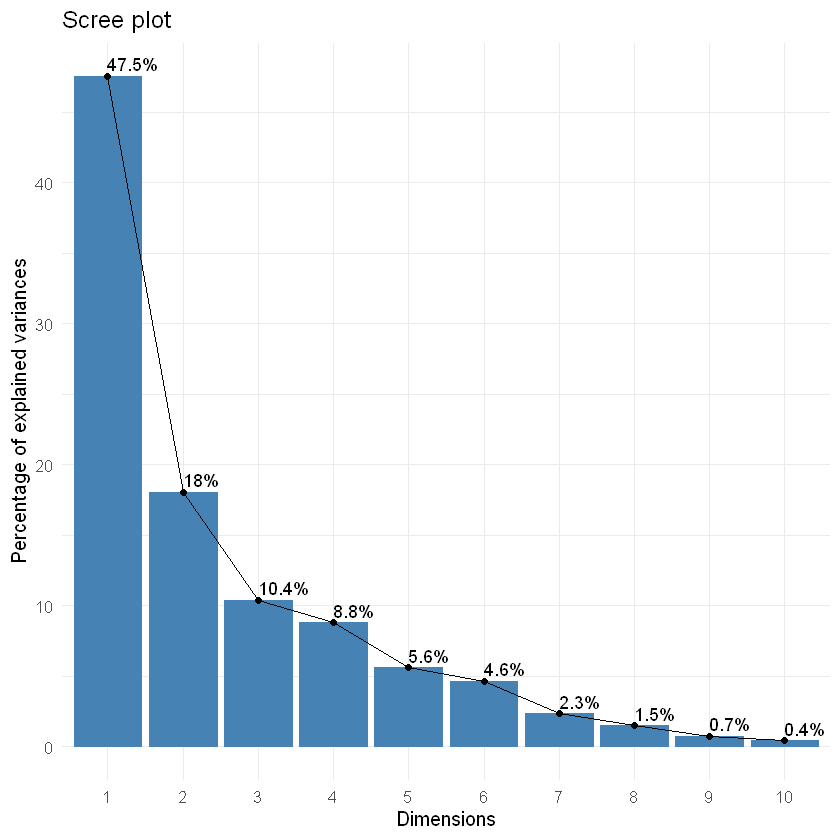



==== Kommunalitäten (über die ersten 3 PCs) ====


Table: Communalities

                     Variable             Communality 
-------------------  -------------------  ------------
BDOC_pct             BDOC_pct             0.471       
average_DOC_sample   average_DOC_sample   0.468       
BGA_PC_ugperL        BGA_PC_ugperL        0.306       
Chlorophyll_ugperL   Chlorophyll_ugperL   0.288       
pH                   pH                   0.261       
pctComp.2            pctComp.2            0.257       
pctComp.3            pctComp.3            0.235       
Turbidity_FNU        Turbidity_FNU        0.201       
CO2_Flux             CO2_Flux             0.173       
ODO_mgperL           ODO_mgperL           0.172       
Air_temp             Air_temp             0.169       
💾 Gespeichert unter C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_A: 13_* und 14_* Dateien.


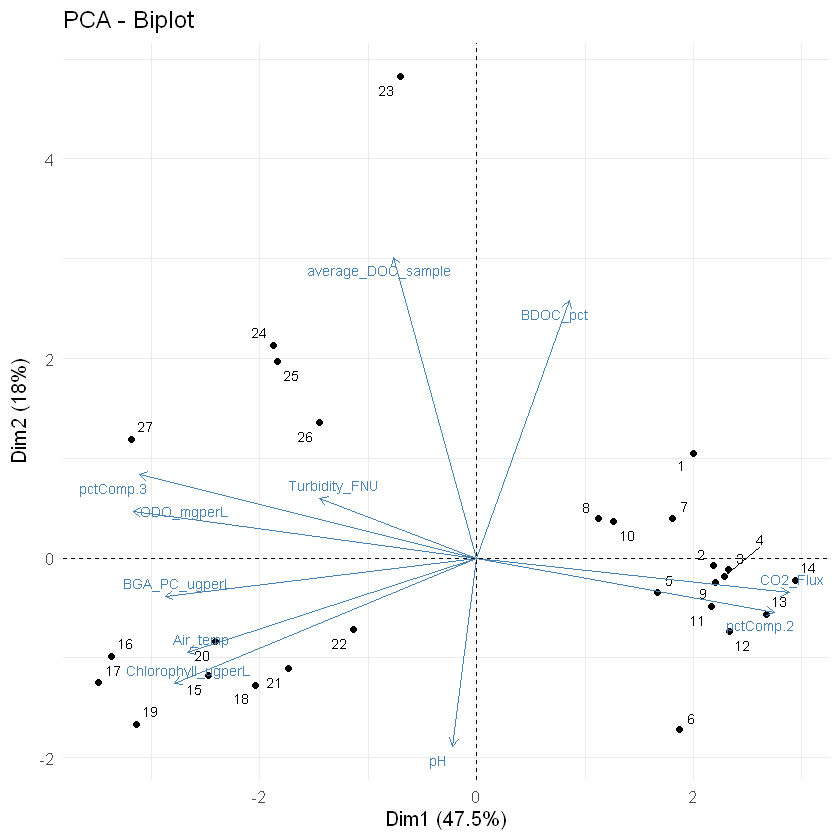

In [46]:
## ==== PCA (angepasst an deine Pfade & Daten) ====
suppressPackageStartupMessages({
  library(factoextra); library(ggplot2); library(knitr)
})

## Pfade
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A")
if(!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

## Finales Variablenset bestimmen
vars_fallback <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
                   "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
                   "pctComp.2","pctComp.3","Air_temp")
vars_use <- if (exists("cur")) intersect(cur, colnames(dat_cc)) else intersect(vars_fallback, colnames(dat_cc))

stopifnot("Zu wenig Variablen für PCA." = length(vars_use) >= 3)

dat_cc_best <- dat_cc[, vars_use, drop = FALSE]
dat_cc_best <- dat_cc_best[complete.cases(dat_cc_best), , drop = FALSE]
stopifnot("Zu wenige vollständige Fälle für PCA." = nrow(dat_cc_best) >= 5)

show_h1(sprintf("PCA auf %d Variablen, N=%d", length(vars_use), nrow(dat_cc_best)))
note(sprintf("Variablen: %s", paste(vars_use, collapse=", ")))

## PCA (auf Korrelationsstruktur)
pca <- prcomp(dat_cc_best, center = TRUE, scale. = TRUE)

## Eigenwerte & Varianzaufklärung
eigenvalues <- pca$sdev^2
var_expl    <- eigenvalues / sum(eigenvalues)
cum_expl    <- cumsum(var_expl)
ev_out <- data.frame(
  PC         = paste0("PC", seq_along(eigenvalues)),
  Eigenwert  = round(eigenvalues, 3),
  Var_Anteil = round(100*var_expl, 2),
  Var_kumul  = round(100*cum_expl, 2)
)

show_h1("Eigenwerte & erklärte Varianz")
show_tbl(ev_out, "Eigenwerte / Varianz (%)")
write.csv(ev_out, file.path(out_dir, "13_PCA_Eigenwerte_Varianz.csv"), row.names = FALSE)

## Screeplot (PNG + Anzeige)
sp <- factoextra::fviz_eig(pca, addlabels = TRUE) + ggplot2::theme_minimal(base_size = 12)
print(sp)
ggplot2::ggsave(file.path(out_dir, "13_PCA_Screeplot.png"), sp, width = 16, height = 10, units = "cm", dpi = 200)

## Ladungen & Scores
loadings <- round(pca$rotation, 3)
scores   <- as.data.frame(pca$x)
show_h1("Ladungen (Loadings)")
show_tbl(as.data.frame(loadings), "Komponentenladungen (gerundet)")
write.csv(loadings, file.path(out_dir, "13_PCA_Loadings.csv"))
write.csv(scores,   file.path(out_dir, "13_PCA_Scores.csv"), row.names = FALSE)

## Biplot (PNG + Anzeige)
bp <- factoextra::fviz_pca_biplot(pca, repel = TRUE, labelsize = 3) + ggplot2::theme_minimal(base_size = 12)
print(bp)
ggplot2::ggsave(file.path(out_dir, "13_PCA_Biplot.png"), bp, width = 16, height = 12, units = "cm", dpi = 200)

## Kommunalitäten (über empfohlene PC-Zahl)
kaiser_k <- max(1L, sum(eigenvalues >= 1 - 1e-8))
cum_k    <- which(cum_expl >= 0.70)[1]; if(is.na(cum_k)) cum_k <- length(eigenvalues)
empf_pcs <- min(kaiser_k, cum_k)

L  <- as.matrix(pca$rotation)
H2 <- rowSums(L[, seq_len(empf_pcs), drop = FALSE]^2)
comm_df <- data.frame(Variable = rownames(L), Communality = round(H2, 3))

show_h1(sprintf("Kommunalitäten (über die ersten %d PCs)", empf_pcs))
show_tbl(comm_df[order(-comm_df$Communality), ], "Communalities")
write.csv(comm_df, file.path(out_dir, "14_PCA_Communalities.csv"), row.names = FALSE)

cat("💾 Gespeichert unter ", out_dir, ": 13_* und 14_* Dateien.\n", sep = "")


In [47]:
## === Communalities (H²) & Uniqueness für die ersten 3 PCs ===
suppressPackageStartupMessages(library(knitr))

# Fallback-Ausgabe (falls bei dir noch nicht definiert)
if(!exists("show_h1"))  show_h1  <- function(x) cat("\n\n==== ", x, " ====\n", sep="")
if(!exists("show_tbl")) show_tbl <- function(df, caption=NULL) print(knitr::kable(df, format="simple", caption=caption, align="l"))

# Pfad (wie bei dir)
if(!exists("out_dir")){
  base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
  out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)
}

# Datenmatrix (nutzt dein finales Set)
stopifnot("dat_cc_best fehlt." = exists("dat_cc_best"))
X <- dat_cc_best
stopifnot(ncol(X) >= 3, nrow(X) >= 5)

# PCA unrotiert auf Korrelationsstruktur
pca <- prcomp(X, center=TRUE, scale.=TRUE)

# H² über die ersten 3 PCs
k  <- min(3L, ncol(X))
L  <- pca$rotation[, 1:k, drop=FALSE]     # Loadings PC1..PCk
H2 <- rowSums(L^2)
U2 <- pmax(0, 1 - H2)                     # Uniqueness

tab_comm <- data.frame(
  Variable    = rownames(L),
  H2          = round(H2, 3),
  Uniqueness  = round(U2, 3),
  Klasse      = cut(H2, c(-Inf, .40, .70, Inf), labels=c("<0.40","0.40–0.70",">0.70")),
  check.names = FALSE
)
tab_comm <- tab_comm[order(-tab_comm$H2), ]

show_h1(sprintf("Communalities über die ersten %d PCs", k))
show_tbl(tab_comm, "H² = Anteil durch PC1–PC3 erklärt; Uniqueness = 1 − H²")

# CSV (numerisch)
write.csv(tab_comm, file.path(out_dir, "15_PCA_Communalities_k3.csv"), row.names=FALSE)

# kurze Zusammenfassung in der Konsole
n_low  <- sum(H2 < .40)
n_mid  <- sum(H2 >= .40 & H2 < .70)
n_high <- sum(H2 >= .70)
cat(sprintf("Zusammenfassung: <0.40: %d | 0.40–0.70: %d | >0.70: %d\n", n_low, n_mid, n_high))




==== Communalities über die ersten 3 PCs ====


Table: H² = Anteil durch PC1–PC3 erklärt; Uniqueness = 1 − H²

                     Variable             H2      Uniqueness   Klasse    
-------------------  -------------------  ------  -----------  ----------
BDOC_pct             BDOC_pct             0.471   0.529        0.40–0.70 
average_DOC_sample   average_DOC_sample   0.468   0.532        0.40–0.70 
BGA_PC_ugperL        BGA_PC_ugperL        0.306   0.694        <0.40     
Chlorophyll_ugperL   Chlorophyll_ugperL   0.288   0.712        <0.40     
pH                   pH                   0.261   0.739        <0.40     
pctComp.2            pctComp.2            0.257   0.743        <0.40     
pctComp.3            pctComp.3            0.235   0.765        <0.40     
Turbidity_FNU        Turbidity_FNU        0.201   0.799        <0.40     
CO2_Flux             CO2_Flux             0.173   0.827        <0.40     
ODO_mgperL           ODO_mgperL           0.172   0.828        <0.40     

In [48]:
p <- ncol(dat_cc_best); n <- nrow(dat_cc_best)
c(p=p, n=n, maxPCs=min(p, n-1))
Matrix::rankMatrix(scale(dat_cc_best, center=TRUE, scale=TRUE))  # effektiver Rang


p      n maxPCs 
    11     27     11

[1] 11
attr(,"method")
[1] "tolNorm2"
attr(,"useGrad")
[1] FALSE
attr(,"tol")
[1] 5.995204e-15

In [49]:
R  <- cor(dat_cc_best, use="complete.obs")
ev <- eigen((R + t(R))/2, symmetric=TRUE)$values
df <- data.frame(PC = paste0("PC", seq_along(ev)),
                 Var_Anteil = round(100*ev/sum(ev), 2))
df


PC,Var_Anteil
<chr>,<dbl>
PC1,47.51
PC2,18.04
PC3,10.37
PC4,8.77
PC5,5.58
PC6,4.63
PC7,2.31
PC8,1.46
PC9,0.75




==== Eigenwerte & erklärte Varianz (Korrelationsmatrix) ====


Table: Eigenwerte / Varianz (%) – 11 Komponenten

PC     Eigenwert   Var_Anteil   Var_kumul 
-----  ----------  -----------  ----------
PC1    5.227       47.51        47.51     
PC2    1.984       18.04        65.55     
PC3    1.141       10.37        75.93     
PC4    0.965       8.77         84.70     
PC5    0.614       5.58         90.28     
PC6    0.509       4.63         94.90     
PC7    0.254       2.31         97.22     
PC8    0.161       1.46         98.68     
PC9    0.082       0.75         99.43     
PC10   0.044       0.40         99.83     
PC11   0.019       0.17         100.00    


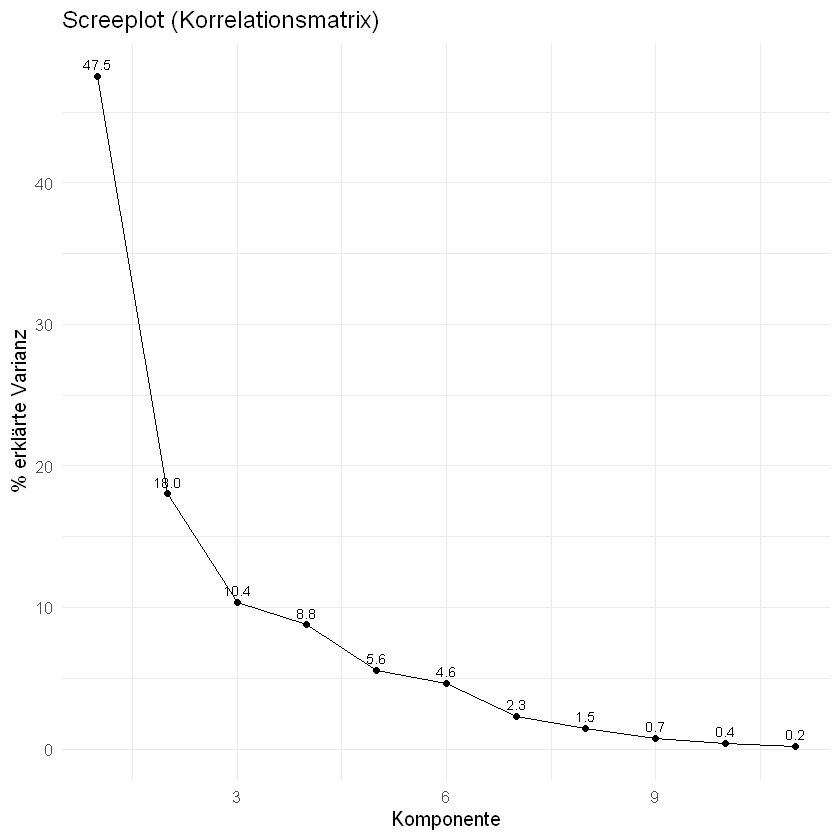

In [50]:
## === Eigenwerte & Screeplot nach KORRELATION (zeigt alle 11) ===
suppressPackageStartupMessages(library(Matrix))

# Korrelationsmatrix (stabilisiert)
R <- cor(dat_cc_best, use="complete.obs")
ev <- eigen((R + t(R))/2, symmetric=TRUE)$values
if (any(!is.finite(ev)) || min(ev) <= 1e-8) {
  note("nearPD auf R angewendet (Stabilisierung).")
  R  <- as.matrix(nearPD(R, corr=TRUE)$mat)
  ev <- eigen(R, symmetric=TRUE)$values
}

p          <- length(ev)            # = Zahl Variablen (z.B. 11)
var_expl   <- ev / sum(ev)
cum_expl   <- cumsum(var_expl)
ev_out_cor <- data.frame(
  PC         = paste0("PC", seq_len(p)),
  Eigenwert  = round(ev, 3),
  Var_Anteil = round(100*var_expl, 2),
  Var_kumul  = round(100*cum_expl, 2)
)

show_h1("Eigenwerte & erklärte Varianz (Korrelationsmatrix)")
show_tbl(ev_out_cor, "Eigenwerte / Varianz (%) – 11 Komponenten")
write.csv(ev_out_cor, file.path(out_dir, "13_PCA_Eigenwerte_Varianz.csv"), row.names=FALSE)

# Screeplot (11 Punkte)
library(ggplot2)
df_scree <- data.frame(PC = seq_len(p), Var = 100*var_expl)
g <- ggplot(df_scree, aes(PC, Var)) +
  geom_line() + geom_point() +
  geom_text(aes(label=sprintf("%.1f", Var)), vjust=-0.6, size=3) +
  labs(x="Komponente", y="% erklärte Varianz", title="Screeplot (Korrelationsmatrix)") +
  theme_minimal(base_size=12)
print(g)
ggsave(file.path(out_dir, "13_PCA_Screeplot_.png"), g, width=16, height=10, units="cm", dpi=200)


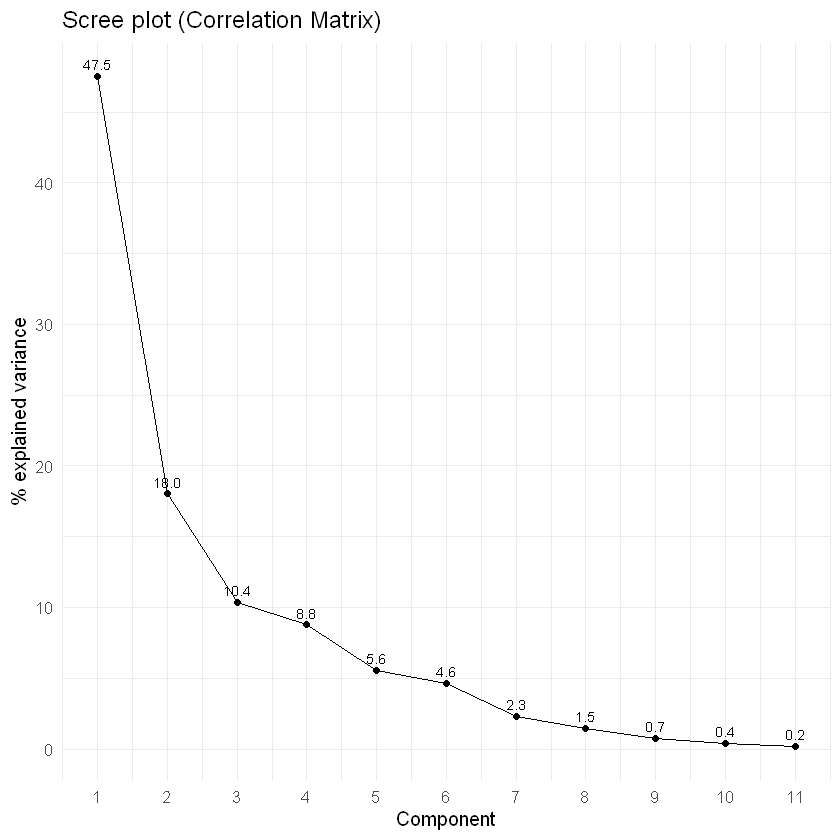

In [51]:
# --- Scree plot (11 points, English labels) ---
library(ggplot2)

df_scree <- data.frame(Component = seq_len(p), ExplainedVar = 100 * var_expl)

g <- ggplot(df_scree, aes(Component, ExplainedVar)) +
  geom_line() + geom_point() +
  geom_text(aes(label = sprintf("%.1f", ExplainedVar)), vjust = -0.6, size = 3) +
  scale_x_continuous(breaks = seq_len(p)) +
  labs(title = "Scree plot (Correlation Matrix)",
       x = "Component",
       y = "% explained variance") +
  theme_minimal(base_size = 12)

print(g)
ggsave(file.path(out_dir, "13_PCA_Screeplot_COR_en.png"),
       g, width = 16, height = 10, units = "cm", dpi = 200)


### PCA-Biplot mit river_name   
Vestari=rot, Virkisa=grün   
VM=▲, NM=●  
Label=site_nr

Anmerkung: PNG gespeichert: 13_PCA_Biplot_custom.png


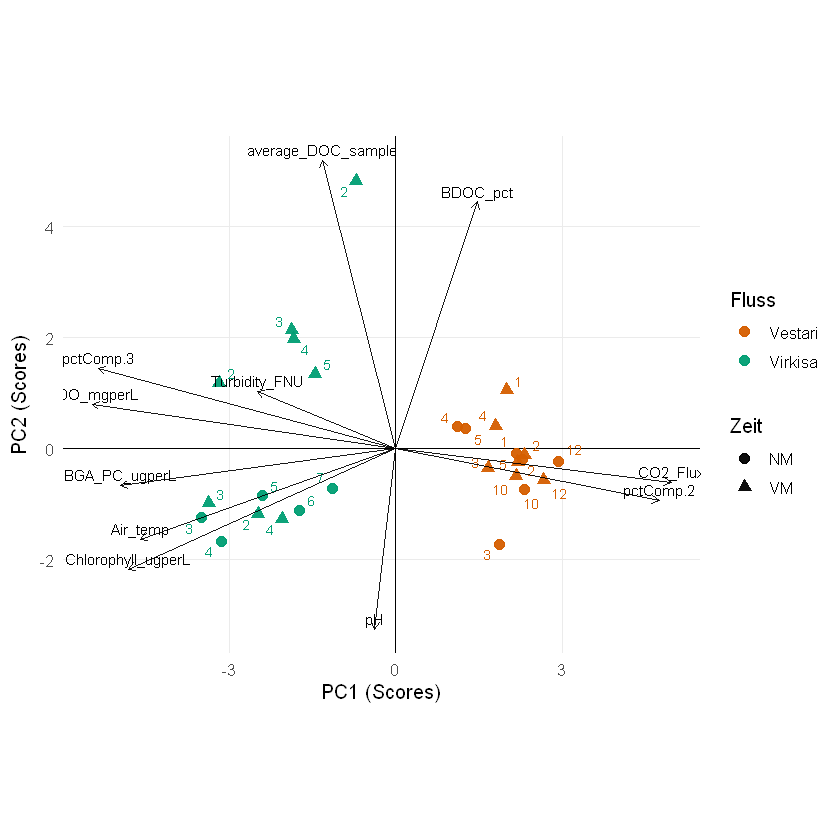

In [52]:
## ==== PCA-Biplot: Vestari=rot, Virkisa=grün; VM=▲, NM=●; Label=site_nr ====
suppressPackageStartupMessages({ library(ggplot2); library(ggrepel); library(dplyr) })

## Pfade
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A")
if(!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

## Variablenset (falls 'cur' existiert, sonst 11er-Set)
vars_fallback <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
                   "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
                   "pctComp.2","pctComp.3","Air_temp")
vars_use <- if (exists("cur")) intersect(cur, colnames(raw)) else intersect(vars_fallback, colnames(raw))
stopifnot("Zu wenig Variablen für PCA." = length(vars_use) >= 3)

## Helper: numerisch machen (Komma -> Punkt)
if(!exists("to_numeric_df")){
  to_numeric_df <- function(df){
    out <- df
    out[] <- lapply(out, function(x){
      if(is.character(x) || is.factor(x)){ x <- gsub(",", ".", as.character(x)); suppressWarnings(as.numeric(x)) }
      else { suppressWarnings(as.numeric(x)) }
    })
    out
  }
}

## Gemeinsamer Frame aus raw: Variablen + Meta
stopifnot(all(c("river_name","day_time","site_nr") %in% names(raw)))
X_full   <- to_numeric_df(raw[, vars_use, drop = FALSE])   # nur Mess-Variablen numerisch
meta_all <- raw[, c("river_name","day_time","site_nr")]

## Einmal nach vollständigen Fällen filtern → Indizes passen sicher
idx <- complete.cases(X_full)
X   <- X_full[idx, , drop = FALSE]
meta <- meta_all[idx, , drop = FALSE]

stopifnot("Zu wenige vollständige Fälle." = nrow(X) >= 5)

## PCA
pca <- prcomp(X, center = TRUE, scale. = TRUE)
eig <- pca$sdev^2

scores <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2])
scores$river    <- case_when(grepl("virk", tolower(meta$river_name)) ~ "Virkisa",
                             grepl("vest", tolower(meta$river_name)) ~ "Vestari",
                             TRUE ~ as.character(meta$river_name))
scores$day_time <- as.character(meta$day_time)
scores$site_nr  <- as.character(meta$site_nr)

## Variablenpfeile (korrelationsbasiert)
var_cor <- as.data.frame(sweep(pca$rotation[,1:2], 2, sqrt(eig[1:2]), `*`))
names(var_cor) <- c("Dim1","Dim2"); var_cor$var <- rownames(var_cor)

## Pfeile skalieren (passen in die Score-Wolke)
scale_arrows <- function(ind_df, var_df){
  xr <- range(ind_df$PC1); yr <- range(ind_df$PC2)
  xs <- max(abs(var_df$Dim1)); ys <- max(abs(var_df$Dim2))
  sf <- 0.85 * min(diff(xr)/xs, diff(yr)/ys)
  transform(var_df, Dim1 = Dim1*sf, Dim2 = Dim2*sf)
}
var_plot <- scale_arrows(scores, var_cor)

## Plot (Vestari=rot, Virkisa=grün; VM=▲(17), NM=●(19); Label=site_nr)
p <- ggplot() +
  geom_hline(yintercept=0, linewidth=0.2) +
  geom_vline(xintercept=0, linewidth=0.2) +
  geom_point(data=scores, aes(PC1, PC2, color=river, shape=day_time), size=2.8, alpha=0.95) +
  geom_text_repel(data=scores, aes(PC1, PC2, label=site_nr, color=river),
                  size=3, show.legend=FALSE, max.overlaps=100) +
  geom_segment(data=var_plot, aes(x=0, y=0, xend=Dim1, yend=Dim2),
               arrow=arrow(length=unit(0.18,"cm")), linewidth=0.4, alpha=0.9) +
  geom_text(data=var_plot, aes(Dim1, Dim2, label=var), size=3.2, vjust=-0.4) +
  scale_color_manual(values=c("Vestari"="#D55E00", "Virkisa"="#009E73")) +
  scale_shape_manual(values=c("VM"=17, "NM"=19)) +
  labs(x="PC1 (Scores)", y="PC2 (Scores)", color="Fluss", shape="Zeit") +
  coord_equal() +
  theme_minimal(base_size=12) +
  theme(legend.position="right", panel.grid.minor=element_blank())

print(p)
ggsave(file.path(out_dir, "13_PCA_Biplot_custom.png"), p,
       width=18, height=14, units="cm", dpi=200)

note("PNG gespeichert: 13_PCA_Biplot_custom.png")


# Tabellen

#### a) Korrelationskoeffizienten
Korrelationskoeffizienten (Faktorenladungen) jedes einzelnen Faktors mit jeder der untersuchten Variablen 

In [53]:
## === Faktorenladungen (unrotiert, k = 3) — pur ===
suppressPackageStartupMessages({ library(psych); library(Matrix) })

# Pfade
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A"); if(!dir.exists(out_dir)) dir.create(out_dir, TRUE)

# Variablenset: 'cur' falls vorhanden, sonst 11er-Set ohne pctComp1/4/5
vars_fallback <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
                   "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
                   "pctComp.2","pctComp.3","Air_temp")
vars_use <- if (exists("cur")) intersect(cur, colnames(dat_cc)) else intersect(vars_fallback, colnames(dat_cc))
stopifnot("Zu wenig Variablen." = length(vars_use) >= 3)

# Daten (vollständige Fälle)
X <- dat_cc[, vars_use, drop = FALSE]
X <- X[complete.cases(X), , drop = FALSE]
stopifnot("Zu wenige vollständige Fälle." = nrow(X) >= 5)

# Korrelationsmatrix + Stabilisierung
R  <- cor(X, use = "complete.obs")
ev <- eigen((R + t(R))/2, symmetric = TRUE, only.values = TRUE)$values
if (any(!is.finite(ev)) || min(ev) <= 1e-8) R <- as.matrix(nearPD(R, corr=TRUE)$mat)

# PCA auf R: unrotiert, k = 3
k <- min(3L, ncol(R))
fa_unrot <- psych::principal(R, nfactors = k, rotate = "none")

# Tabelle bauen
L <- round(unclass(fa_unrot$loadings), 3)
colnames(L) <- paste0("Faktor", seq_len(ncol(L)))
tab_unrot <- data.frame(Variable = rownames(L), L, check.names = FALSE)

# Ausgabe + Speichern
if(!exists("show_h1")) show_h1 <- function(txt) cat("\n\n==== ", txt, " ====\n", sep="")
if(!exists("show_tbl")) show_tbl <- function(df, caption=NULL) print(knitr::kable(df, format="simple", caption=caption, align="l"))

show_h1("Faktorenladungen (unrotiert, k=3)")
show_tbl(tab_unrot, "Korrelationskoeffizienten Variable × Faktor (pur)")

write.csv(tab_unrot, file.path(out_dir, "06_Loadings_unrotiert.csv"), row.names = FALSE)




==== Faktorenladungen (unrotiert, k=3) ====


Table: Korrelationskoeffizienten Variable × Faktor (pur)

                     Variable             Faktor1   Faktor2   Faktor3 
-------------------  -------------------  --------  --------  --------
average_DOC_sample   average_DOC_sample   0.222     0.874     -0.289  
BDOC_pct             BDOC_pct             -0.248    0.748     0.450   
CO2_Flux             CO2_Flux             -0.836    -0.101    0.197   
Chlorophyll_ugperL   Chlorophyll_ugperL   0.809     -0.365    0.331   
ODO_mgperL           ODO_mgperL           0.919     0.135     -0.039  
BGA_PC_ugperL        BGA_PC_ugperL        0.833     -0.111    0.436   
Turbidity_FNU        Turbidity_FNU        0.419     0.173     0.416   
pH                   pH                   0.064     -0.547    -0.353  
pctComp.2            pctComp.2            -0.798    -0.157    0.374   
pctComp.3            pctComp.3            0.901     0.243     -0.240  
Air_temp             Air_temp             

#### b) jeweiligen Faktor stark korrelierenden Variablen (Korrelationskoeffizienten > 0.50)

In [54]:
## Variablen × Faktoren (unrotiert, nur |L| ≥ 0.50 sichtbar)
suppressPackageStartupMessages({ library(psych); library(Matrix); library(knitr) })
if(!exists("show_h1"))  show_h1  <- function(txt) cat("\n\n==== ", txt, " ====\n", sep="")
if(!exists("show_tbl")) show_tbl <- function(df, caption=NULL) print(knitr::kable(df, format="simple", caption=caption, align="l"))

# Pfade
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)

# Variablenset
vars_fallback <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
                   "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
                   "pctComp.2","pctComp.3","Air_temp")
vars_use <- if (exists("cur")) intersect(cur, colnames(dat_cc)) else intersect(vars_fallback, colnames(dat_cc))
stopifnot(length(vars_use) >= 3)

# Daten & Korrelationsmatrix
X <- dat_cc[, vars_use, drop=FALSE]; X <- X[complete.cases(X), , drop=FALSE]
stopifnot(nrow(X) >= 5)
R <- cor(X, use="complete.obs")
ev <- eigen((R+t(R))/2, symmetric=TRUE, only.values=TRUE)$values
if(any(!is.finite(ev)) || min(ev) <= 1e-8) R <- as.matrix(nearPD(R, corr=TRUE)$mat)

# Unrotierte Ladungen (k=3)
k <- min(3L, ncol(R))
L <- unclass(psych::principal(R, nfactors=k, rotate="none")$loadings)  # numeric
colnames(L) <- paste0("Faktor", seq_len(ncol(L)))
L <- round(L, 3)

# Sichtbarkeitsschwelle
thr <- 0.50
L_show <- apply(L, 2, function(col) ifelse(abs(col) >= thr, sprintf("%+.3f", col), ""))
tab <- data.frame(Variable = rownames(L), L_show, check.names=FALSE)

show_h1("Stark korrelierende Variablen je Faktor (unrotiert)")
show_tbl(tab, sprintf("Einträge nur bei |L| ≥ %.2f", thr))

# Speichern
write.csv(tab, file.path(out_dir, "06f_Loadings_unrotiert_masked_gt050.csv"), row.names=FALSE)




==== Stark korrelierende Variablen je Faktor (unrotiert) ====


Table: Einträge nur bei |L| ≥ 0.50

                     Variable             Faktor1   Faktor2   Faktor3 
-------------------  -------------------  --------  --------  --------
average_DOC_sample   average_DOC_sample             +0.874            
BDOC_pct             BDOC_pct                       +0.748            
CO2_Flux             CO2_Flux             -0.836                      
Chlorophyll_ugperL   Chlorophyll_ugperL   +0.809                      
ODO_mgperL           ODO_mgperL           +0.919                      
BGA_PC_ugperL        BGA_PC_ugperL        +0.833                      
Turbidity_FNU        Turbidity_FNU                                    
pH                   pH                             -0.547            
pctComp.2            pctComp.2            -0.798                      
pctComp.3            pctComp.3            +0.901                      
Air_temp             Air_temp             +0.7

#### stand 

In [55]:
## Varianz & erklärter Anteil durch 3 Faktoren (unrotiert, k=3)
suppressPackageStartupMessages({ library(psych); library(Matrix); library(knitr) })
if(!exists("show_h1"))  show_h1  <- function(txt) cat("\n\n==== ", txt, " ====\n", sep="")
if(!exists("show_tbl")) show_tbl <- function(df, caption=NULL) print(knitr::kable(df, format="simple", caption=caption, align="l"))

# Pfade
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)

# Variablenset
vars_fallback <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
                   "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
                   "pctComp.2","pctComp.3","Air_temp")
vars_use <- if (exists("cur")) intersect(cur, colnames(dat_cc)) else intersect(vars_fallback, colnames(dat_cc))
stopifnot(length(vars_use) >= 3)

# Daten & R
X <- dat_cc[, vars_use, drop=FALSE]; X <- X[complete.cases(X), , drop=FALSE]; stopifnot(nrow(X) >= 5)
R <- cor(X, use="complete.obs")
ev <- eigen((R+t(R))/2, symmetric=TRUE, only.values=TRUE)$values
if(any(!is.finite(ev)) || min(ev) <= 1e-8) R <- as.matrix(nearPD(R, corr=TRUE)$mat)

# Unrotierte PCA, k=3
k <- min(3L, ncol(R))
L <- unclass(psych::principal(R, nfactors=k, rotate="none")$loadings)
H2 <- rowSums(L[, 1:k, drop=FALSE]^2)

# Tabelle (numerisch für CSV)
tab_num <- data.frame(
  Variable                    = rownames(L),
  Var_stand_0_1               = rep(1, nrow(L)),
  Anteil_durch_3Faktoren      = H2,
  Anteil_durch_3Faktoren_pct  = 100*H2,
  Restvarianz                 = pmax(0, 1 - H2),
  check.names = FALSE
)

# Anzeige wie gewünscht (formatiert)
tab_print <- transform(tab_num,
  Var_stand_0_1              = sprintf("%.3f", Var_stand_0_1),
  Anteil_durch_3Faktoren     = sprintf("%.3f", Anteil_durch_3Faktoren),
  Anteil_durch_3Faktoren_pct = sprintf("%.1f", Anteil_durch_3Faktoren_pct),
  Restvarianz                = sprintf("%.3f", Restvarianz)
)

show_h1("Varianz & erklärter Anteil (3 Faktoren, unrotiert)")
show_tbl(tab_print, "Ursprungsvarianz (=1), H², H² in %, Rest")

write.csv(tab_num, file.path(out_dir, "06g_Varianz_und_H2_pro_Variable.csv"), row.names=FALSE)




==== Varianz & erklärter Anteil (3 Faktoren, unrotiert) ====


Table: Ursprungsvarianz (=1), H², H² in %, Rest

                     Variable             Var_stand_0_1   Anteil_durch_3Faktoren   Anteil_durch_3Faktoren_pct   Restvarianz 
-------------------  -------------------  --------------  -----------------------  ---------------------------  ------------
average_DOC_sample   average_DOC_sample   1.000           0.897                    89.7                         0.103       
BDOC_pct             BDOC_pct             1.000           0.823                    82.3                         0.177       
CO2_Flux             CO2_Flux             1.000           0.748                    74.8                         0.252       
Chlorophyll_ugperL   Chlorophyll_ugperL   1.000           0.897                    89.7                         0.103       
ODO_mgperL           ODO_mgperL           1.000           0.864                    86.4                         0.136       
BGA_PC_ugpe

In [63]:
## Communalities (H²) – Auswertung & Handlungshinweise
suppressPackageStartupMessages(library(knitr))

stopifnot(exists("dat_cc_best"))
X <- dat_cc_best
k <- 3

# unrotierte PCA (H² identisch zu Varimax bei orthogonaler Rotation)
pca <- prcomp(X, center=TRUE, scale.=TRUE)
L   <- pca$rotation[, 1:k, drop=FALSE]
H2  <- rowSums(L^2)
U2  <- pmax(0, 1 - H2)

comm <- data.frame(
  Variable   = rownames(L),
  H2         = round(H2, 3),
  Uniqueness = round(U2, 3),
  Klasse     = cut(H2, c(-Inf, .40, .70, Inf), labels=c("<0.40","0.40–0.70",">0.70")),
  check.names = FALSE
)
comm <- comm[order(-comm$H2), ]

# Anzeige
if(!exists("show_h1"))  show_h1  <- function(x) cat("\n\n==== ", x, " ====\n", sep="")
if(!exists("show_tbl")) show_tbl <- function(df, caption=NULL) print(knitr::kable(df, format="simple", caption=caption, align="l"))

show_h1("Communalities über die ersten 3 PCs")
show_tbl(comm, "H² = Anteil durch PC1–PC3 erklärt; Uniqueness = 1 − H²")

# Zusammenfassung + Handlungsvorschlag
n_low  <- sum(H2 < .40); n_mid <- sum(H2 >= .40 & H2 < .70); n_high <- sum(H2 >= .70)
cat(sprintf("Summary H²: <0.40=%d | 0.40–0.70=%d | >0.70=%d\n", n_low, n_mid, n_high))
cat(sprintf("H² (min/median/mean/max): %.2f / %.2f / %.2f / %.2f\n",
            min(H2), median(H2), mean(H2), max(H2)))

if(n_low > 0){
  cat("Hinweis: Variablen mit H² < 0.40 sind schwach repräsentiert – ",
      "entweder vorsichtig interpretieren oder für Sensitivitätsanalyse entfernen.\n", sep="")
} else {
  cat("Hinweis: Keine H² < 0.40 – gute Repräsentation der Variablen durch 3 PCs.\n")
}

# Speichern
if(!exists("out_dir")){
  base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
  out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)
}
write.csv(comm, file.path(out_dir, "15_PCA_Communalities_k3.csv"), row.names=FALSE)




==== Communalities über die ersten 3 PCs ====


Table: H² = Anteil durch PC1–PC3 erklärt; Uniqueness = 1 − H²

                     Variable             H2      Uniqueness   Klasse    
-------------------  -------------------  ------  -----------  ----------
BDOC_pct             BDOC_pct             0.471   0.529        0.40–0.70 
average_DOC_sample   average_DOC_sample   0.468   0.532        0.40–0.70 
BGA_PC_ugperL        BGA_PC_ugperL        0.306   0.694        <0.40     
Chlorophyll_ugperL   Chlorophyll_ugperL   0.288   0.712        <0.40     
pH                   pH                   0.261   0.739        <0.40     
pctComp.2            pctComp.2            0.257   0.743        <0.40     
pctComp.3            pctComp.3            0.235   0.765        <0.40     
Turbidity_FNU        Turbidity_FNU        0.201   0.799        <0.40     
CO2_Flux             CO2_Flux             0.173   0.827        <0.40     
ODO_mgperL           ODO_mgperL           0.172   0.828        <0.40     

In [64]:
## === Communalities (Initial vs. Extraction) – PCA auf Korrelationsmatrix, k=3 ===
suppressPackageStartupMessages({ library(psych); library(Matrix); library(knitr) })

# Fallback-Ausgabe
if(!exists("show_h1"))  show_h1  <- function(x) cat("\n\n==== ", x, " ====\n", sep="")
if(!exists("show_tbl")) show_tbl <- function(df, caption=NULL)
  print(knitr::kable(df, format="simple", caption=caption, align="l"))

# Pfad
if(!exists("out_dir")){
  base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
  out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)
}

# Daten (nutzt dein finales Datenset)
stopifnot("dat_cc_best fehlt." = exists("dat_cc_best"))
X <- dat_cc_best
X <- X[complete.cases(X), , drop=FALSE]; stopifnot(nrow(X) >= 5)

# Korrelationsmatrix (stabilisieren falls nötig)
R  <- cor(X, use="complete.obs"); R <- (R + t(R))/2
ev <- eigen(R, symmetric=TRUE, only.values=TRUE)$values
if(min(ev) <= 1e-8) R <- as.matrix(nearPD(R, corr=TRUE)$mat)

# Unrotierte PCA-Ladungen (SPSS-äquivalent)
k   <- min(3L, ncol(R))
L0  <- unclass(psych::principal(R, nfactors=k, rotate="none")$loadings)[, 1:k, drop=FALSE]
H2  <- rowSums(L0^2)                         # Communality je Variable (durch 3 Faktoren erklärt)

# Tabelle wie im Dokument: Initial (=1), Extraction (=H²)
comm_doc <- data.frame(
  Variable   = rownames(L0),
  Initial    = rep(1, nrow(L0)),
  Extraction = round(H2, 3),
  check.names = FALSE
)
show_h1("Communalities (Initial vs. Extraction)")
show_tbl(comm_doc, "Varianzen (standardisiert) vor und nach Extraktion von 3 Faktoren (PCA)")

# Optional: Nachweis, dass Varimax die H² nicht ändert
Lr  <- unclass(psych::principal(R, nfactors=k, rotate="varimax")$loadings)[, 1:k, drop=FALSE]
H2r <- rowSums(Lr^2)
cat(sprintf("Check: H² unrot. vs. Varimax identisch? %s\n",
            if(all.equal(H2, H2r)) "Ja" else "Nein"))

# Speichern
write.csv(comm_doc, file.path(out_dir, "06_Communalities_Initial_Extraction.csv"), row.names=FALSE)




==== Communalities (Initial vs. Extraction) ====


Table: Varianzen (standardisiert) vor und nach Extraktion von 3 Faktoren (PCA)

                     Variable             Initial   Extraction 
-------------------  -------------------  --------  -----------
average_DOC_sample   average_DOC_sample   1         0.897      
BDOC_pct             BDOC_pct             1         0.823      
CO2_Flux             CO2_Flux             1         0.748      
Chlorophyll_ugperL   Chlorophyll_ugperL   1         0.897      
ODO_mgperL           ODO_mgperL           1         0.864      
BGA_PC_ugperL        BGA_PC_ugperL        1         0.897      
Turbidity_FNU        Turbidity_FNU        1         0.379      
pH                   pH                   1         0.428      
pctComp.2            pctComp.2            1         0.801      
pctComp.3            pctComp.3            1         0.928      
Air_temp             Air_temp             1         0.691      
Check: H² unrot. vs. Varimax identi

In [65]:
# H² & U² aus unrotierter PCA (k=3)
k  <- 3
L  <- pca$rotation[, 1:k, drop=FALSE]
H2 <- rowSums(L^2); U2 <- 1 - H2

data.frame(Variable=rownames(L), H2=round(H2,3), U2=round(U2,3),
           Flag = ifelse(H2<.40, "<0.40", ifelse(H2<.70,"0.40–0.70", ">=0.70")))


,Variable,H2,U2,Flag
,<chr>,<dbl>,<dbl>,<chr>
average_DOC_sample,average_DOC_sample,0.468,0.532,0.40–0.70
BDOC_pct,BDOC_pct,0.471,0.529,0.40–0.70
CO2_Flux,CO2_Flux,0.173,0.827,<0.40
Chlorophyll_ugperL,Chlorophyll_ugperL,0.288,0.712,<0.40
ODO_mgperL,ODO_mgperL,0.172,0.828,<0.40
BGA_PC_ugperL,BGA_PC_ugperL,0.306,0.694,<0.40
Turbidity_FNU,Turbidity_FNU,0.201,0.799,<0.40
pH,pH,0.261,0.739,<0.40
pctComp.2,pctComp.2,0.257,0.743,<0.40


# Ermittlung der Faktorenladungen nach Applikation einer Rotation

In [56]:
## Variablen × Faktoren (Varimax, nur |L| ≥ 0.50 sichtbar)
suppressPackageStartupMessages({ library(psych); library(Matrix); library(knitr) })
if(!exists("show_h1"))  show_h1  <- function(txt) cat("\n\n==== ", txt, " ====\n", sep="")
if(!exists("show_tbl")) show_tbl <- function(df, caption=NULL) print(knitr::kable(df, format="simple", caption=caption, align="l"))

# Pfade/Ordner
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)

# Variablenset
vars_fallback <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
                   "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
                   "pctComp.2","pctComp.3","Air_temp")
vars_use <- if (exists("cur")) intersect(cur, colnames(dat_cc)) else intersect(vars_fallback, colnames(dat_cc))
stopifnot(length(vars_use) >= 3)

# Daten & R
X <- dat_cc[, vars_use, drop=FALSE]; X <- X[complete.cases(X), , drop=FALSE]; stopifnot(nrow(X) >= 5)
R <- cor(X, use="complete.obs")
ev <- eigen((R+t(R))/2, symmetric=TRUE, only.values=TRUE)$values
if(any(!is.finite(ev)) || min(ev) <= 1e-8) R <- as.matrix(nearPD(R, corr=TRUE)$mat)

# Varimax, k=3
k <- min(3L, ncol(R))
Lr <- unclass(psych::principal(R, nfactors=k, rotate="varimax")$loadings)  # Variablen × Faktoren
colnames(Lr) <- paste0("Faktor ", seq_len(ncol(Lr)))
Lr <- round(Lr, 3)

# Maskierung: nur |L| >= 0.50 anzeigen
thr <- 0.50
L_show <- apply(Lr, 2, function(col) ifelse(abs(col) >= thr, sprintf("%+.3f", col), ""))
tab <- data.frame(Variable = rownames(Lr), L_show, check.names = FALSE)

show_h1("Variablen × Faktoren (Varimax)")
show_tbl(tab, sprintf("Einträge nur bei |L| ≥ %.2f (k=3)", thr))

write.csv(tab, file.path(out_dir, "07_Varimax_Loadings_masked_gt050.csv"), row.names=FALSE)




==== Variablen × Faktoren (Varimax) ====


Table: Einträge nur bei |L| ≥ 0.50 (k=3)

                     Variable             Faktor 1   Faktor 2   Faktor 3 
-------------------  -------------------  ---------  ---------  ---------
average_DOC_sample   average_DOC_sample   +0.681                +0.592   
BDOC_pct             BDOC_pct                                   +0.894   
CO2_Flux             CO2_Flux             -0.749                         
Chlorophyll_ugperL   Chlorophyll_ugperL              +0.885              
ODO_mgperL           ODO_mgperL           +0.732     +0.573              
BGA_PC_ugperL        BGA_PC_ugperL                   +0.898              
Turbidity_FNU        Turbidity_FNU                   +0.516              
pH                   pH                                         -0.653   
pctComp.2            pctComp.2            -0.845                         
pctComp.3            pctComp.3            +0.878                         
Air_temp             Air_

pdf 
  2

Anmerkung: PNG gespeichert: 07_Varimax_Loadings_3D.png


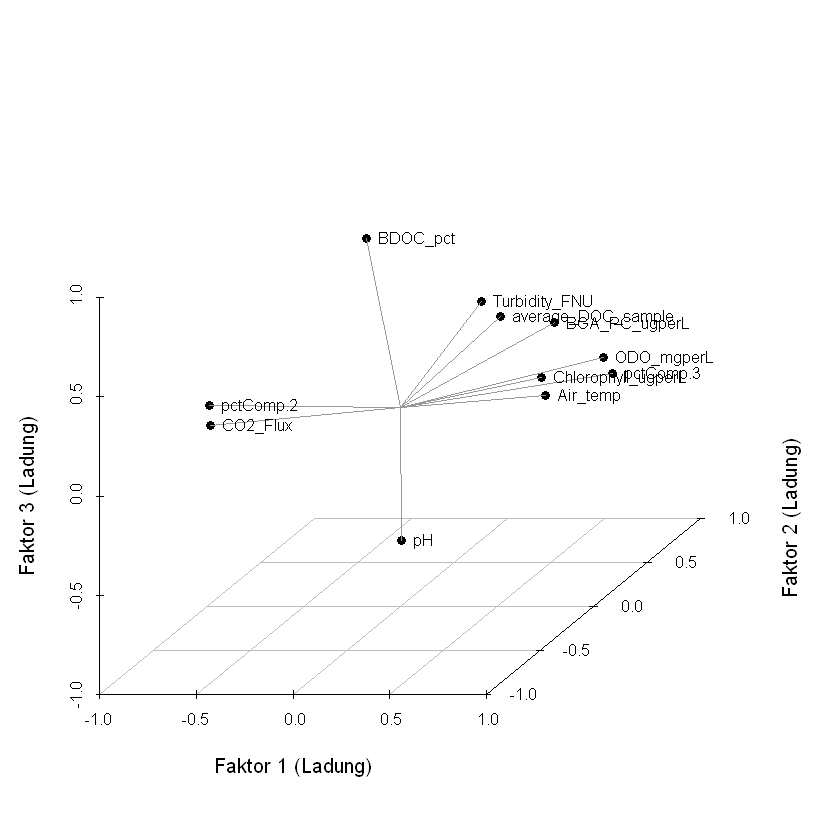

In [57]:
## 3D-Plot der Faktorladungen (Varimax, k=3)
req <- c("psych","Matrix","scatterplot3d")
to_install <- req[!req %in% rownames(installed.packages())]
if(length(to_install)) install.packages(to_install, quiet=TRUE)
invisible(lapply(req, library, character.only=TRUE))

# Pfade
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)
if(!exists("note")) note <- function(txt) cat("Anmerkung:", txt, "\n")

# Variablenset (cur bevorzugt)
vars_fallback <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
                   "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
                   "pctComp.2","pctComp.3","Air_temp")
vars_use <- if (exists("cur")) intersect(cur, colnames(dat_cc)) else intersect(vars_fallback, colnames(dat_cc))
stopifnot(length(vars_use) >= 3)

# Daten & R
X <- dat_cc[, vars_use, drop=FALSE]
X <- X[complete.cases(X), , drop=FALSE]; stopifnot(nrow(X) >= 5)
R <- cor(X, use="complete.obs")
ev <- eigen((R+t(R))/2, symmetric=TRUE, only.values=TRUE)$values
if(any(!is.finite(ev)) || min(ev) <= 1e-8) { R <- as.matrix(nearPD(R, corr=TRUE)$mat) }

# Varimax-Ladungen (k=3)
k <- min(3L, ncol(R))
Lr <- unclass(psych::principal(R, nfactors=k, rotate="varimax")$loadings)[,1:3,drop=FALSE]
colnames(Lr) <- c("Faktor 1","Faktor 2","Faktor 3")

# ---- PNG speichern ----
png(file.path(out_dir, "07_Varimax_Loadings_3D.png"), width=1600, height=1400, res=180)
s3d <- scatterplot3d(Lr[,1], Lr[,2], Lr[,3],
  xlim=c(-1,1), ylim=c(-1,1), zlim=c(-1,1),
  xlab="Faktor 1 (Ladung)", ylab="Faktor 2 (Ladung)", zlab="Faktor 3 (Ladung)",
  grid=TRUE, box=FALSE, pch=19, color="black")
# Labels & „Pfeile“ vom Ursprung
xy0 <- s3d$xyz.convert(0,0,0)
xyE <- s3d$xyz.convert(Lr[,1], Lr[,2], Lr[,3])
segments(xy0$x, xy0$y, xyE$x, xyE$y, col="grey60", lwd=1)
text(xyE$x, xyE$y, labels=rownames(Lr), pos=4, cex=0.8)
dev.off()
note("PNG gespeichert: 07_Varimax_Loadings_3D.png")

# ---- Anzeige im Notebook (gleicher Plot) ----
s3d <- scatterplot3d(Lr[,1], Lr[,2], Lr[,3],
  xlim=c(-1,1), ylim=c(-1,1), zlim=c(-1,1),
  xlab="Faktor 1 (Ladung)", ylab="Faktor 2 (Ladung)", zlab="Faktor 3 (Ladung)",
  grid=TRUE, box=FALSE, pch=19, color="black")
xy0 <- s3d$xyz.convert(0,0,0); xyE <- s3d$xyz.convert(Lr[,1], Lr[,2], Lr[,3])
segments(xy0$x, xy0$y, xyE$x, xyE$y, col="grey60", lwd=1)
text(xyE$x, xyE$y, labels=rownames(Lr), pos=4, cex=0.8)


pdf 
  2

Anmerkung: PNG gespeichert: 07_Varimax_Loadings_3D_threshold.png
Beschriftet: 5 Variablen (Mode = threshold; thr=0.80; topN=8)


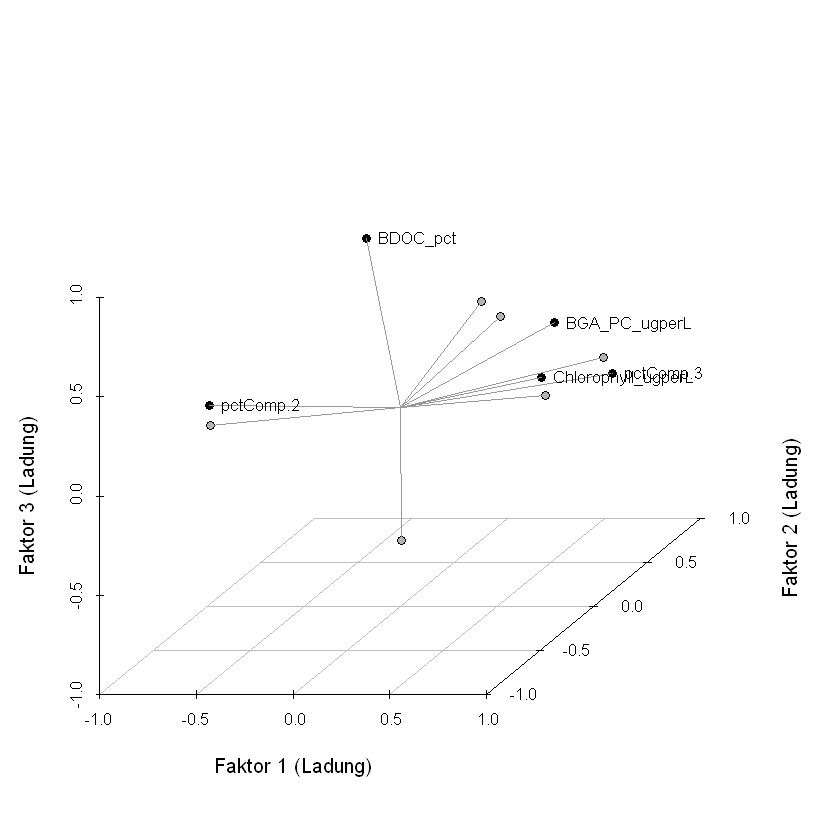

In [58]:
## 3D-Plot der Faktorladungen (Varimax, k = 3) — mit steuerbaren Labels
suppressPackageStartupMessages({
  library(psych); library(Matrix); library(scatterplot3d)
})

## Pfade
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)
if(!exists("note")) note <- function(txt) cat("Anmerkung:", txt, "\n")

## Variablenset (cur bevorzugt)
vars_fallback <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
                   "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
                   "pctComp.2","pctComp.3","Air_temp")
vars_use <- if (exists("cur")) intersect(cur, colnames(dat_cc)) else intersect(vars_fallback, colnames(dat_cc))
stopifnot(length(vars_use) >= 3)

## Daten & Korrelationsmatrix (stabilisiert)
X <- dat_cc[, vars_use, drop = FALSE]
X <- X[complete.cases(X), , drop = FALSE]; stopifnot(nrow(X) >= 5)
R <- cor(X, use = "complete.obs"); R <- (R + t(R)) / 2
ev <- eigen(R, symmetric = TRUE, only.values = TRUE)$values
if(any(!is.finite(ev)) || min(ev) <= 1e-8) R <- as.matrix(nearPD(R, corr = TRUE)$mat)

## Varimax-Ladungen (k=3)
k  <- min(3L, ncol(R))
Lr <- unclass(psych::principal(R, nfactors = k, rotate = "varimax")$loadings)[, 1:3, drop = FALSE]
colnames(Lr) <- c("Faktor 1","Faktor 2","Faktor 3")

## ===== LABEL SETTINGS (edit here) ============================================
label_mode <- "threshold"  # "threshold"  |  "topN"  |  "all"
thr        <- 0.80         # nur bei label_mode = "threshold": |L|max >= thr
topN       <- 8            # nur bei label_mode = "topN": Top-N nach |L|max
## ============================================================================

pick_idx <- function(L){
  if(label_mode == "all") return(seq_len(nrow(L)))
  mag <- apply(abs(L), 1, max)          # größte Ladung je Variable (über F1–F3)
  if(label_mode == "topN") return(order(mag, decreasing = TRUE)[seq_len(min(topN, length(mag)))])
  if(label_mode == "threshold") return(which(mag >= thr))
  seq_len(nrow(L))
}
lab_idx <- pick_idx(Lr)
rest    <- setdiff(seq_len(nrow(Lr)), lab_idx)

## ---------- PNG speichern ----------
png(file.path(out_dir, sprintf("07_Varimax_Loadings_3D_%s.png", label_mode)),
    width = 1600, height = 1400, res = 180)
s3d <- scatterplot3d(Lr[,1], Lr[,2], Lr[,3],
  xlim=c(-1,1), ylim=c(-1,1), zlim=c(-1,1),
  xlab="Faktor 1 (Ladung)", ylab="Faktor 2 (Ladung)", zlab="Faktor 3 (Ladung)",
  grid=TRUE, box=FALSE, pch=19, color="black")
xy0 <- s3d$xyz.convert(0,0,0)
xyE <- s3d$xyz.convert(Lr[,1], Lr[,2], Lr[,3])
segments(xy0$x, xy0$y, xyE$x, xyE$y, col="grey60", lwd=1)
# Punkte: nicht beschriftete leicht grau
if(length(rest)) points(xyE$x[rest], xyE$y[rest], pch=19, col="grey70", cex=0.8)
# Labels (nur Auswahl)
text(xyE$x[lab_idx], xyE$y[lab_idx], labels = rownames(Lr)[lab_idx], pos = 4, cex = 0.85)
dev.off()
note(sprintf("PNG gespeichert: 07_Varimax_Loadings_3D_%s.png", label_mode))

## ---------- Anzeige im Notebook ----------
s3d <- scatterplot3d(Lr[,1], Lr[,2], Lr[,3],
  xlim=c(-1,1), ylim=c(-1,1), zlim=c(-1,1),
  xlab="Faktor 1 (Ladung)", ylab="Faktor 2 (Ladung)", zlab="Faktor 3 (Ladung)",
  grid=TRUE, box=FALSE, pch=19, color="black")
xy0 <- s3d$xyz.convert(0,0,0); xyE <- s3d$xyz.convert(Lr[,1], Lr[,2], Lr[,3])
segments(xy0$x, xy0$y, xyE$x, xyE$y, col="grey60", lwd=1)
if(length(rest)) points(xyE$x[rest], xyE$y[rest], pch=19, col="grey70", cex=0.8)
text(xyE$x[lab_idx], xyE$y[lab_idx], labels = rownames(Lr)[lab_idx], pos = 4, cex = 0.85)

cat(sprintf("Beschriftet: %d Variablen (Mode = %s; thr=%.2f; topN=%s)\n",
            length(lab_idx), label_mode, thr, if(is.numeric(topN)) topN else "NA"))


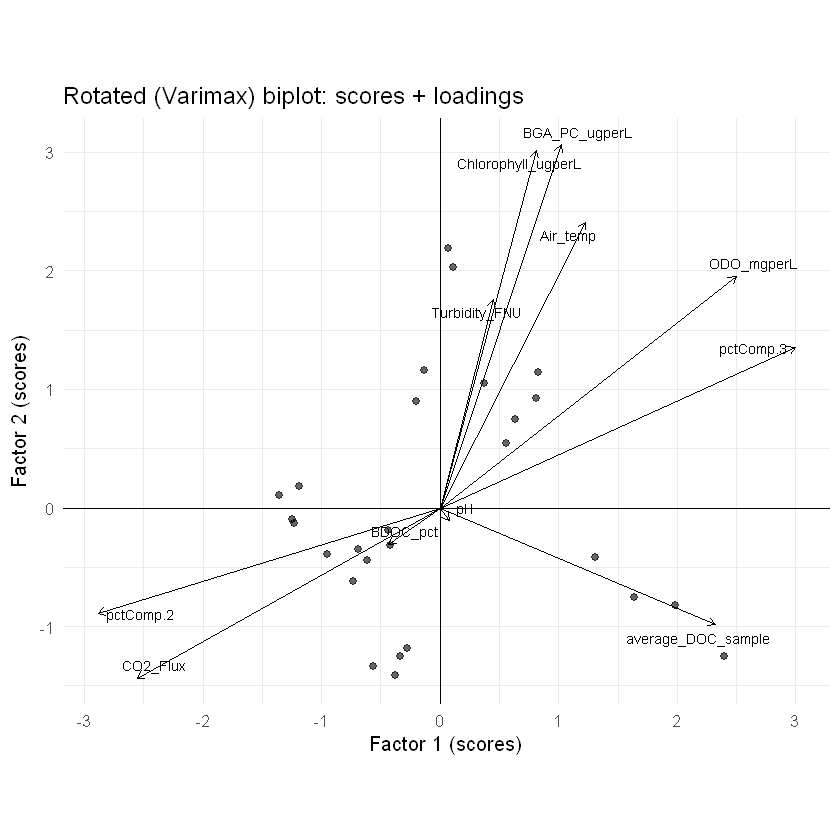

In [59]:
## Rotated (Varimax) biplot with scores, Factors 1–2
suppressPackageStartupMessages({ library(psych); library(ggplot2); library(ggrepel) })

# Daten (finales Set)
X <- dat_cc_best  # vollständige Fälle aus deinem PCA-Block

# Varimax mit Scores
k <- 3
fa <- psych::principal(X, nfactors=k, rotate="varimax", scores=TRUE)

scores <- as.data.frame(fa$scores)[,1:2]; colnames(scores) <- c("F1","F2")
Lr     <- unclass(fa$loadings)[,1:2,drop=FALSE]; colnames(Lr) <- c("F1","F2")
Lr <- as.data.frame(Lr); Lr$var <- rownames(Lr)

# Pfeile skalieren (damit gut in die Score-Wolke passen)
scale_arrows <- function(ind_df, var_df){
  xr <- range(ind_df$F1); yr <- range(ind_df$F2)
  xs <- max(abs(var_df$F1)); ys <- max(abs(var_df$F2))
  sf <- 0.85 * min( diff(xr)/xs, diff(yr)/ys )
  transform(var_df, F1 = F1*sf, F2 = F2*sf)
}
Lplot <- scale_arrows(scores, Lr)

p <- ggplot() +
  geom_hline(yintercept=0, linewidth=0.2) +
  geom_vline(xintercept=0, linewidth=0.2) +
  geom_point(data=scores, aes(F1, F2), alpha=0.6, size=2) +
  geom_segment(data=Lplot, aes(x=0,y=0,xend=F1,yend=F2),
               arrow=arrow(length=unit(0.18,"cm")), linewidth=0.4) +
  geom_text_repel(data=Lplot, aes(F1, F2, label=var), size=3, max.overlaps=100) +
  coord_equal() +
  labs(x="Factor 1 (scores)", y="Factor 2 (scores)",
       title="Rotated (Varimax) biplot: scores + loadings") +
  theme_minimal(base_size=12)
print(p)

ggsave(file.path(out_dir, "13_PCA_Biplot_Varimax_2D.png"),
       p, width=18, height=14, units="cm", dpi=200)


#### rotierte 2D-Biplots

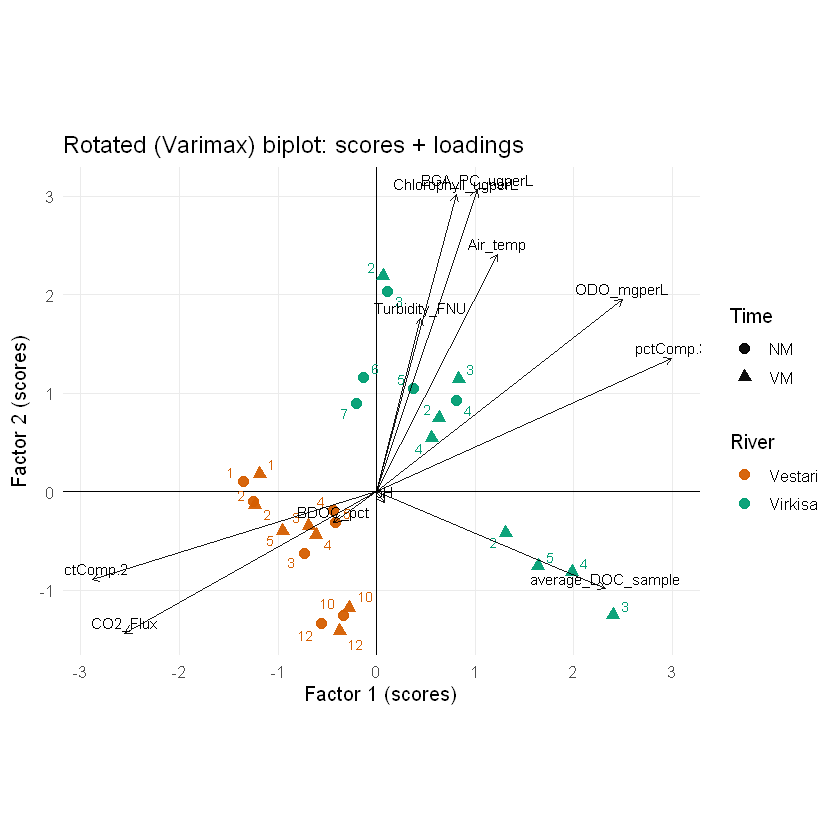

In [60]:
## === Rotated (Varimax) biplot: Vestari=rot, Virkisa=grün; VM=▲, NM=●; Label=site_nr ===
suppressPackageStartupMessages({ library(psych); library(dplyr); library(ggplot2); library(ggrepel) })

# Pfade
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)

# Variablenset
vars_fallback <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
                   "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
                   "pctComp.2","pctComp.3","Air_temp")
vars_use <- if (exists("cur")) intersect(cur, colnames(raw)) else intersect(vars_fallback, colnames(raw))
stopifnot("Zu wenig Variablen." = length(vars_use) >= 3)

# Helper: numerisch
if(!exists("to_numeric_df")){
  to_numeric_df <- function(df){
    out <- df
    out[] <- lapply(out, function(x){
      if(is.character(x) || is.factor(x)){ x <- gsub(",", ".", as.character(x)); suppressWarnings(as.numeric(x)) }
      else { suppressWarnings(as.numeric(x)) }
    }); out
  }
}

# Daten + Meta gemeinsam filtern (Kohärenz!)
stopifnot(all(c("river_name","day_time","site_nr") %in% names(raw)))
X_full <- to_numeric_df(raw[, vars_use, drop=FALSE])
cc_idx <- complete.cases(X_full)
X      <- X_full[cc_idx, , drop=FALSE]

meta <- raw[cc_idx, c("river_name","day_time","site_nr")]
meta <- meta %>%
  mutate(
    river = case_when(
      grepl("virk",  tolower(river_name)) ~ "Virkisa",
      grepl("vest",  tolower(river_name)) ~ "Vestari",
      TRUE ~ as.character(river_name)
    ),
    day_time = as.character(day_time),
    site_nr  = as.character(site_nr)
  )

# Varimax mit Scores (k=3)
k  <- 3L
fa <- psych::principal(X, nfactors=k, rotate="varimax", scores=TRUE)

scores <- as.data.frame(fa$scores[,1:2, drop=FALSE]); colnames(scores) <- c("F1","F2")
scores$river    <- meta$river
scores$day_time <- meta$day_time
scores$site_nr  <- meta$site_nr

# Loadings (F1,F2) + sinnvolle Skalierung der Pfeile
Lr <- as.data.frame(unclass(fa$loadings)[,1:2, drop=FALSE]); colnames(Lr) <- c("F1","F2")
Lr$var <- rownames(Lr)

scale_arrows <- function(ind_df, var_df){
  xr <- range(ind_df$F1); yr <- range(ind_df$F2)
  xs <- max(abs(var_df$F1)); ys <- max(abs(var_df$F2))
  sf <- 0.85 * min( diff(xr)/xs, diff(yr)/ys )
  transform(var_df, F1 = F1*sf, F2 = F2*sf)
}
Lplot <- scale_arrows(scores, Lr)

# Plot
p <- ggplot() +
  geom_hline(yintercept=0, linewidth=0.2) +
  geom_vline(xintercept=0, linewidth=0.2) +
  geom_point(data=scores, aes(F1, F2, color=river, shape=day_time), size=2.8, alpha=0.95) +
  geom_text_repel(data=scores, aes(F1, F2, label=site_nr, color=river),
                  size=3, show.legend=FALSE, max.overlaps=100) +
  geom_segment(data=Lplot, aes(x=0, y=0, xend=F1, yend=F2),
               arrow=arrow(length=unit(0.18,"cm")), linewidth=0.4, alpha=0.9) +
  geom_text(data=Lplot, aes(F1, F2, label=var), size=3.2, vjust=-0.4) +
  scale_color_manual(values=c("Vestari"="#D55E00", "Virkisa"="#009E73")) +  # rot / grün
  scale_shape_manual(values=c("VM"=17, "NM"=19)) +                          # ▲ / ●
  labs(title="Rotated (Varimax) biplot: scores + loadings",
       x="Factor 1 (scores)", y="Factor 2 (scores)",
       color="River", shape="Time") +
  coord_equal() +
  theme_minimal(base_size=12) +
  theme(legend.position="right", panel.grid.minor=element_blank())

print(p)
ggsave(file.path(out_dir, "13_PCA_Biplot_Varimax_custom.png"),
       p, width=18, height=14, units="cm", dpi=200)


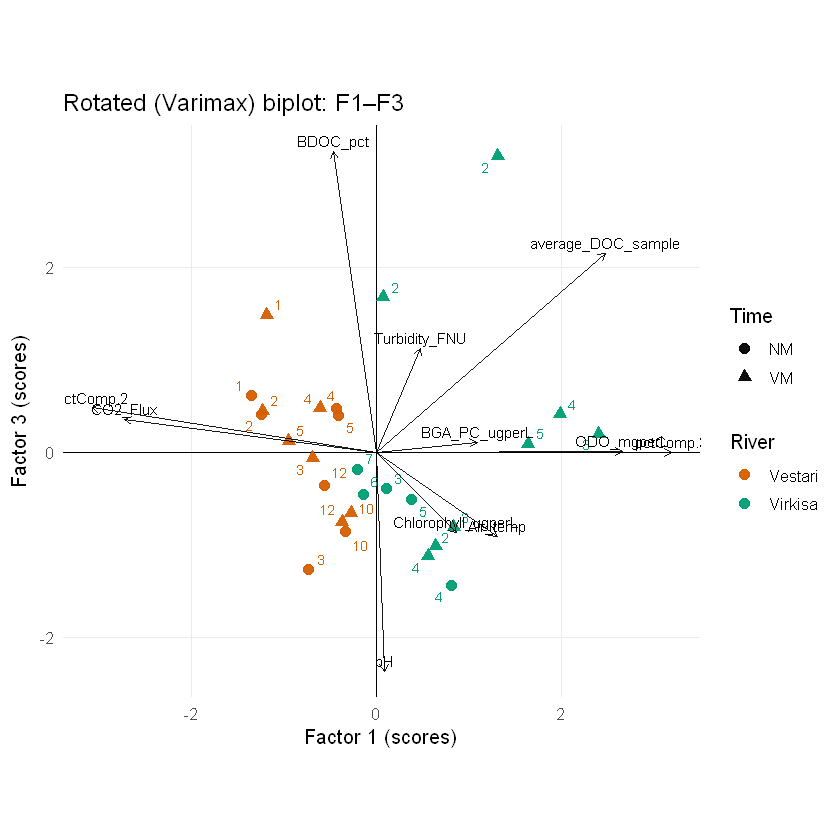

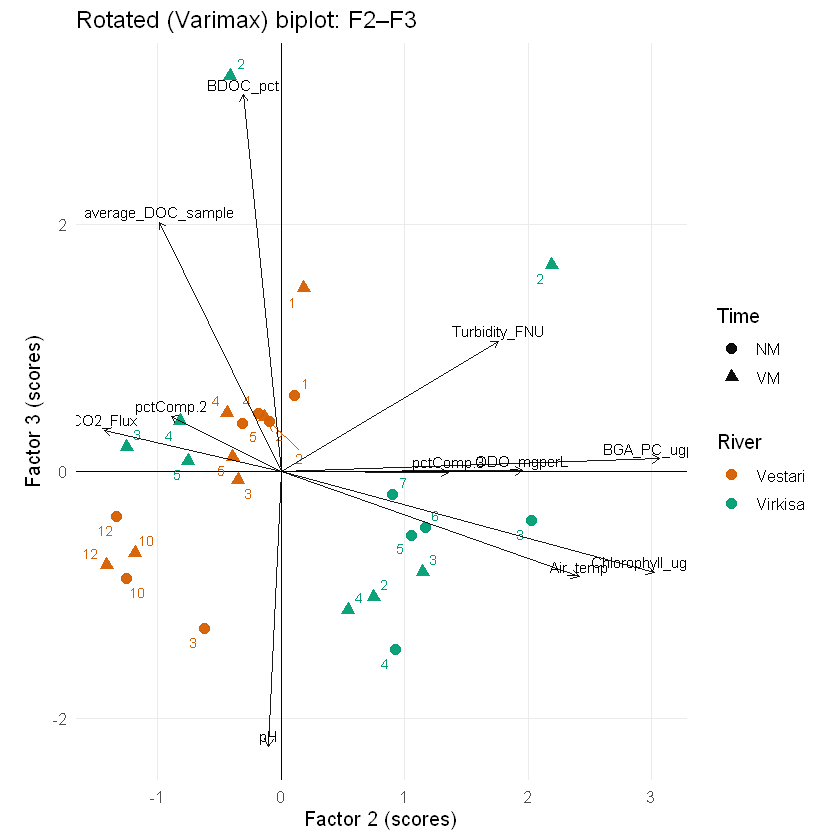

In [61]:
## === Rotated (Varimax) biplots: F1–F3 und F2–F3, mit Fluss-Farben & Symbolen ===
suppressPackageStartupMessages({ library(psych); library(dplyr); library(ggplot2); library(ggrepel) })

# Pfade
base_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"
out_dir  <- file.path(base_dir, "PCA_A"); dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)

# Variablenset (cur bevorzugt)
vars_fallback <- c("average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
                   "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
                   "pctComp.2","pctComp.3","Air_temp")
vars_use <- if (exists("cur")) intersect(cur, colnames(raw)) else intersect(vars_fallback, colnames(raw))
stopifnot(length(vars_use) >= 3, all(c("river_name","day_time","site_nr") %in% names(raw)))

# Helper
if(!exists("to_numeric_df")){
  to_numeric_df <- function(df){
    out <- df
    out[] <- lapply(out, function(x){
      if(is.character(x) || is.factor(x)){ x <- gsub(",", ".", as.character(x)); suppressWarnings(as.numeric(x)) }
      else { suppressWarnings(as.numeric(x)) }
    }); out
  }
}
scale_arrows <- function(ind_df, var_df){
  xr <- range(ind_df[,1]); yr <- range(ind_df[,2])
  xs <- max(abs(var_df[,1])); ys <- max(abs(var_df[,2]))
  sf <- 0.85 * min(diff(xr)/xs, diff(yr)/ys)
  var_df * sf
}

# vollständige Fälle auf Basis von RAW (damit Meta passt)
X_full <- to_numeric_df(raw[, vars_use, drop=FALSE])
cc_idx <- complete.cases(X_full)
X      <- X_full[cc_idx, , drop=FALSE]

meta <- raw[cc_idx, c("river_name","day_time","site_nr")] %>%
  mutate(
    river = case_when(
      grepl("virk", tolower(river_name)) ~ "Virkisa",
      grepl("vest", tolower(river_name)) ~ "Vestari",
      TRUE ~ as.character(river_name)
    ),
    day_time = as.character(day_time),
    site_nr  = as.character(site_nr)
  )

# Varimax mit Scores
k  <- 3L
fa <- psych::principal(X, nfactors=k, rotate="varimax", scores=TRUE)

scores <- as.data.frame(fa$scores[,1:3, drop=FALSE])
colnames(scores) <- paste0("F", 1:3)
scores$river    <- meta$river
scores$day_time <- meta$day_time
scores$site_nr  <- meta$site_nr

Lr <- as.data.frame(unclass(fa$loadings)[,1:3, drop=FALSE])
colnames(Lr) <- paste0("F", 1:3)
Lr$var <- rownames(Lr)

make_plot <- function(i, j, filename){
  ind <- scores[, c(i, j)]
  colnames(ind) <- c("A","B")
  vars <- Lr[, c(i, j)]
  colnames(vars) <- c("A","B")
  vars_scaled <- scale_arrows(ind, vars)
  Lplot <- cbind(vars_scaled, var=Lr$var)

  p <- ggplot() +
    geom_hline(yintercept=0, linewidth=0.2) +
    geom_vline(xintercept=0, linewidth=0.2) +
    geom_point(data = transform(ind, river=scores$river, day_time=scores$day_time, site_nr=scores$site_nr),
               aes(A, B, color=river, shape=day_time), size=2.8, alpha=0.95) +
    geom_text_repel(data = transform(ind, river=scores$river, lab=scores$site_nr),
                    aes(A, B, label=lab, color=river), size=3, show.legend=FALSE, max.overlaps=100) +
    geom_segment(data=Lplot, aes(x=0,y=0,xend=A,yend=B),
                 arrow=arrow(length=unit(0.18,"cm")), linewidth=0.4, alpha=0.9) +
    geom_text(data=Lplot, aes(A, B, label=var), size=3.1, vjust=-0.4) +
    scale_color_manual(values=c("Vestari"="#D55E00","Virkisa"="#009E73")) +
    scale_shape_manual(values=c("VM"=17,"NM"=19), drop=FALSE) +
    coord_equal() +
    labs(title=sprintf("Rotated (Varimax) biplot: F%d–F%d", i, j),
         x=sprintf("Factor %d (scores)", i), y=sprintf("Factor %d (scores)", j),
         color="River", shape="Time") +
    theme_minimal(base_size=12) +
    theme(legend.position="right", panel.grid.minor=element_blank())
  print(p)
  ggsave(file.path(out_dir, filename), p, width=18, height=14, units="cm", dpi=200)
}

# Gewünschte Paare:
make_plot(1,3, "13_PCA_Biplot_Varimax_2D_F1_F3.png")
make_plot(2,3, "13_PCA_Biplot_Varimax_2D_F2_F3.png")


# ================================================

In [62]:
## ==== Multivariate Tests (Wilks) im Dokument-Format ====
suppressPackageStartupMessages(library(knitr))

# falls 'fit' noch nicht existiert, kurz erzeugen (wie zuvor)
if(!exists("fit")){
  k <- 3L
  fa_rot <- psych::principal(dat[, vars_use, drop=FALSE], nfactors=k, rotate="varimax", scores=TRUE)
  man_df <- cbind(as.data.frame(fa_rot$scores), river = factor(dat$river, levels=c("Vestari","Virkisa")))
  colnames(man_df)[1:3] <- paste0("Faktor", 1:3)
  fit <- manova(cbind(Faktor1, Faktor2, Faktor3) ~ river, data = man_df)
}

sm <- summary(fit, test = "Wilks")
st <- sm$stats[grep("^river$", rownames(sm$stats), ignore.case=TRUE), , drop=FALSE]

# Formatierer (deutsches Komma)
fmt  <- function(x,d=3) format(round(as.numeric(x), d), nsmall=d, decimal.mark=",")
fmt5 <- function(x)     fmt(x,5)
fmtdf<- function(x)     format(as.numeric(x), nsmall=2, trim=TRUE, decimal.mark=",")
fmtp <- function(p)     if(as.numeric(p) < 1e-4) "< ,0001" else sub("\\.", ",", format.pval(as.numeric(p), digits=3))

tab_multi <- data.frame(
  `Test Name` = "Wilks",
  Value       = fmt5(st[,"Wilks"]),
  `Exact F`   = fmt5(st[,"approx F"]),
  `Hypoth. DF`= fmtdf(st[,"num Df"]),
  `Error DF`  = fmtdf(st[,"den Df"]),
  `Sig. of F` = fmtp(st[,"Pr(>F)"]),
  check.names = FALSE
)

show_h1("Multivariate Tests of Significance")
show_tbl(tab_multi)

# optional speichern
write.csv(tab_multi, file.path(out_dir, "21_MANOVA_Wilks_formatiert.csv"), row.names=FALSE)


ERROR: Error in cor(r, use = use): 'x' muss numerisch sein


In [ ]:
## --- Univariate F-Tests (robust; unabhängig von Spaltennamen) ---
# benötigt: man_df (Scores + river), show_h1(), show_tbl(), out_dir vorhanden

one_uni <- function(response){
  fit1 <- aov(as.formula(paste(response, "~ river")), data = man_df)
  tab  <- as.data.frame(summary(fit1)[[1]])

  # Spalten robust identifizieren
  nn <- tolower(gsub("[^a-z]", "", names(tab)))         # "Df","Sum Sq",... -> "df","sumsq",...
  pick <- function(key_pat, default_idx){
    pos <- grep(key_pat, nn)
    if(length(pos)==0) pos <- default_idx
    pos[1]
  }
  c_df <- pick("^df$", 1)
  c_ss <- pick("sumsq|squares", 2)

  # Effekt = 1. Zeile (river), Fehler = letzte Zeile (Residuals)
  df_h <- as.numeric(tab[1, c_df]);  df_e <- as.numeric(tab[nrow(tab), c_df])
  ss_h <- as.numeric(tab[1, c_ss]);  ss_e <- as.numeric(tab[nrow(tab), c_ss])

  ms_h <- ss_h / df_h; ms_e <- ss_e / df_e
  Fval <- ms_h / ms_e
  pval <- stats::pf(Fval, df_h, df_e, lower.tail = FALSE)

  data.frame(
    Variable   = response,
    Hypoth.SS  = ss_h,
    Error.SS   = ss_e,
    Hypoth.MS  = ms_h,
    Error.MS   = ms_e,
    F          = Fval,
    `Sig. of F`= pval,
    check.names = FALSE
  )
}

tab_uni_num <- do.call(rbind, lapply(paste0("Faktor", 1:3), one_uni))

# schön formatiert (Komma als Dezimaltrenner)
fmt3 <- function(x) format(round(x,3), nsmall=3, decimal.mark=",")
fmtp <- function(p) gsub("\\.", ",", format.pval(p, digits=3))
tab_uni_print <- transform(tab_uni_num,
  Hypoth.SS = fmt3(Hypoth.SS),
  Error.SS  = fmt3(Error.SS),
  Hypoth.MS = fmt3(Hypoth.MS),
  Error.MS  = fmt3(Error.MS),
  F         = fmt3(F),
  `Sig. of F` = fmtp(`Sig. of F`)
)

show_h1("Univariate F-tests (river: Vestari vs Virkisa)")
show_tbl(tab_uni_print)

# speichern
write.csv(tab_uni_num,   file.path(out_dir, "21_MANOVA_Univariate_numeric.csv"), row.names=FALSE)
write.csv(tab_uni_print, file.path(out_dir, "21_MANOVA_Univariate_formatiert.csv"), row.names=FALSE)
